In [47]:
import numpy as np
import pandas as pd
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy import stats
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score

Forecasting starting from 2010

In [48]:
Market = pd.read_csv('RealizedVarianceData.csv',skiprows=[0])[['DateID',"SPX2.rv"]]
Market["DateID"] = pd.to_datetime(Market['DateID'],format='%Y%m%d') 
for i in range(1, len(Market)):
    if pd.isna(Market.at[i, "SPX2.rv"]):
        Market.at[i, "SPX2.rv"] = Market.at[i-1, "SPX2.rv"]
d_train = Market[Market["DateID"].dt.year < 2010]
vol_mean=np.mean(d_train["SPX2.rv"])
print(len(d_train))

2611


In [49]:
def pred_sigma(log_sigmasquare,delta,H):
    pred = 0
    coeff=((delta**(H+1/2))*np.cos(H*np.pi)/np.pi)
    for k in range(len(log_sigmasquare)):
        d=(k+delta+1/2)*((k+1/2)**(H+1/2))
        a=log_sigmasquare[-k-1]/d
        pred+=a
    return(pred*coeff)

def M(X,q,lag):
    a=np.mean(abs(np.diff(X[::int(lag)]))**q)
    return(a)

def H_exp(X):
    Delta=np.logspace(1,2.1,100)
    Q=[0.5,0.75,1,1.25,1.5,2]
    Y=np.zeros(len(Delta))   
    h_exp=0
    for q in Q:
        i=0
        for d in Delta:   
            Em=M(X,q,d)
            Y[i]=Em
            i+=1
        Y=np.log10(Y)
        slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(Delta),Y)
        x=[1,2.1]
        y=[1*slope+intercept,2.1*slope+intercept]
        h_exp+=slope/q/len(Q)
    return(h_exp)

In [50]:
H=H_exp(d_train["SPX2.rv"].to_numpy())
d=np.log10(Market["SPX2.rv"].to_numpy())

def pred(d):
    X=np.array([pred_sigma(d[:k+1],1,H) for k in range(len(d)-1)])
    dtilde=d[1:]
    X1=X*np.mean(dtilde/X)
    return X1


def plot():
    delta=1
    dtilde=d[delta:]
    X=np.array([pred_sigma(d[:k+1],delta,H) for k in range(len(d)-delta)])
    plt.plot(dtilde,label="Real")
    plt.plot(X*np.mean(dtilde/X),label="Pred")
    plt.legend()
    plt.show()
X=10**(np.array([0]+list(pred(d))))
Market["Pred"]=X


In [51]:
data_spy = yf.download('SPY', start='2000-01-01', end='2014-01-01')
data_spy.dropna(inplace=True)
data_spy['Returns'] = data_spy['Close'].pct_change()
data_spy.dropna(inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [52]:
volatility = Market['Pred']
date = Market["DateID"]
date = date.iloc[1:].reset_index(drop=True)
date = pd.to_datetime(date, format='%Y%m%d')
true_var = volatility.iloc[1:].reset_index(drop=True)
true_var = pd.to_numeric(true_var, errors='coerce')
true_var.dropna()
true_vol = np.sqrt(true_var)
df1 = pd.DataFrame({'Date': date, 'Volatility': true_vol})
true_vol = df1['Volatility']
data_spy = pd.merge(data_spy, df1, on='Date', how='inner')
data_spy=data_spy[2611:]
print(data_spy)

           Date        Open        High         Low       Close   Adj Close  \
2611 2010-05-25  105.110001  107.870003  104.379997  107.820000   82.977325   
2612 2010-05-26  108.480003  109.470001  106.849998  107.169998   82.477058   
2613 2010-05-27  109.190002  110.800003  108.779999  110.760002   85.239876   
2614 2010-05-28  110.639999  110.720001  108.849998  109.370003   84.170166   
2615 2010-06-01  108.349998  109.949997  107.370003  107.529999   82.754135   
...         ...         ...         ...         ...         ...         ...   
3514 2013-12-24  182.539993  183.009995  182.529999  182.929993  152.204575   
3515 2013-12-26  183.339996  183.960007  183.320007  183.860001  152.978394   
3516 2013-12-27  184.100006  184.179993  183.660004  183.850006  152.970047   
3517 2013-12-30  183.869995  184.020004  183.580002  183.820007  152.945099   
3518 2013-12-31  184.070007  184.690002  183.929993  184.690002  153.668930   

         Volume   Returns  Volatility  
2611  39650

Lower Threshold: 0.0052670499153789465, Upper Threshold: 0.008581675398210337
           Date        Open        High         Low       Close  Adj Close  \
2611 2010-05-25  105.110001  107.870003  104.379997  107.820000  82.977325   
2612 2010-05-26  108.480003  109.470001  106.849998  107.169998  82.477058   
2613 2010-05-27  109.190002  110.800003  108.779999  110.760002  85.239876   
2614 2010-05-28  110.639999  110.720001  108.849998  109.370003  84.170166   
2615 2010-06-01  108.349998  109.949997  107.370003  107.529999  82.754135   

         Volume   Returns  Volatility  
2611  396505200  0.001021    0.013375  
2612  349719300 -0.006029    0.017338  
2613  300870500  0.033498    0.015391  
2614  297933500 -0.012550    0.015162  
2615  277909400 -0.016824    0.014406  
[107.81999969 107.16999817 110.76000214 109.37000275 107.52999878
 110.33000183 110.70999908 106.81999969 105.48999786 106.62000275
 106.05000305 109.15000153 109.68000031 109.51000214 112.
 111.95999908 112.13999

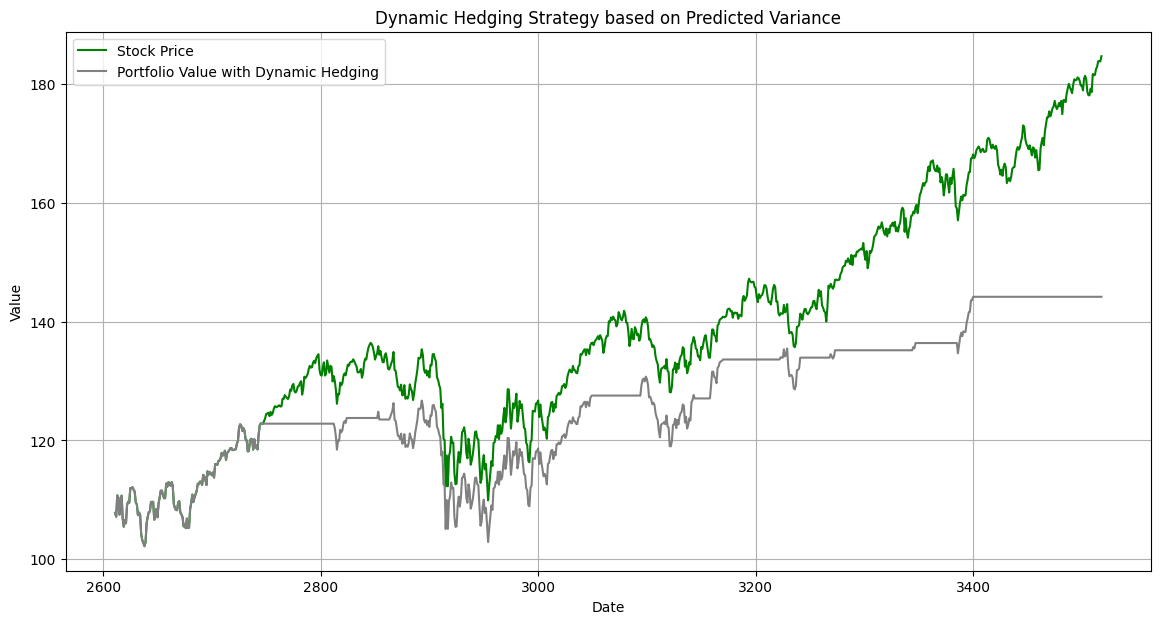

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def dynamic_hedging(data):
    var_pred = np.array(data['Volatility'])
    Close = np.array(data['Close'])
    Stocks = 1
    Money = 0
    MTotal = []

    # Déterminer les seuils dynamiques en utilisant les quantiles
    lower_threshold = np.percentile(var_pred, 25)  # 25ème percentile
    upper_threshold = np.percentile(var_pred, 75)  # 75ème percentile
    
    print(f"Lower Threshold: {lower_threshold}, Upper Threshold: {upper_threshold}")

    for k in range(len(Close)):
        MTotal.append(Stocks * Close[k] + Money)
        
        if var_pred[k] < lower_threshold and Stocks > 0:  # Hedge by selling stocks
            Money = Stocks * Close[k]
            Stocks = 0
        elif var_pred[k] > upper_threshold and Money > 0:  # Reduce hedge by buying stocks
            Stocks = Money / Close[k]
            Money = 0

    return MTotal

# Exemple de données
MTotal = dynamic_hedging(data_spy)
print(data_spy.head())
print(np.array(data_spy['Close']))
print(MTotal)

plt.figure(figsize=(14, 7))
plt.plot(data_spy.index, np.array(data_spy['Close']), color='green', label="Stock Price")
plt.plot(data_spy.index, MTotal, color='grey', label="Portfolio Value with Dynamic Hedging")
plt.title("Dynamic Hedging Strategy based on Predicted Variance")
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()






0.007524808015226839
Step 1: Money = 107.82, Stocks = 0.00, Portfolio Value = 107.82, Volatility = 0.01
Step 2: Money = 107.82, Stocks = 0.00, Portfolio Value = 107.82, Volatility = 0.02
Step 3: Money = 107.82, Stocks = 0.00, Portfolio Value = 107.82, Volatility = 0.02
Step 4: Money = 107.82, Stocks = 0.00, Portfolio Value = 107.82, Volatility = 0.02
Step 5: Money = 107.82, Stocks = 0.00, Portfolio Value = 107.82, Volatility = 0.01
Step 6: Money = 107.82, Stocks = 0.00, Portfolio Value = 107.82, Volatility = 0.01
Step 7: Money = 107.82, Stocks = 0.00, Portfolio Value = 107.82, Volatility = 0.01
Step 8: Money = 107.82, Stocks = 0.00, Portfolio Value = 107.82, Volatility = 0.01
Step 9: Money = 107.82, Stocks = 0.00, Portfolio Value = 107.82, Volatility = 0.01
Step 10: Money = 107.82, Stocks = 0.00, Portfolio Value = 107.82, Volatility = 0.01
Step 11: Money = 107.82, Stocks = 0.00, Portfolio Value = 107.82, Volatility = 0.01
Step 12: Money = 107.82, Stocks = 0.00, Portfolio Value = 107.82

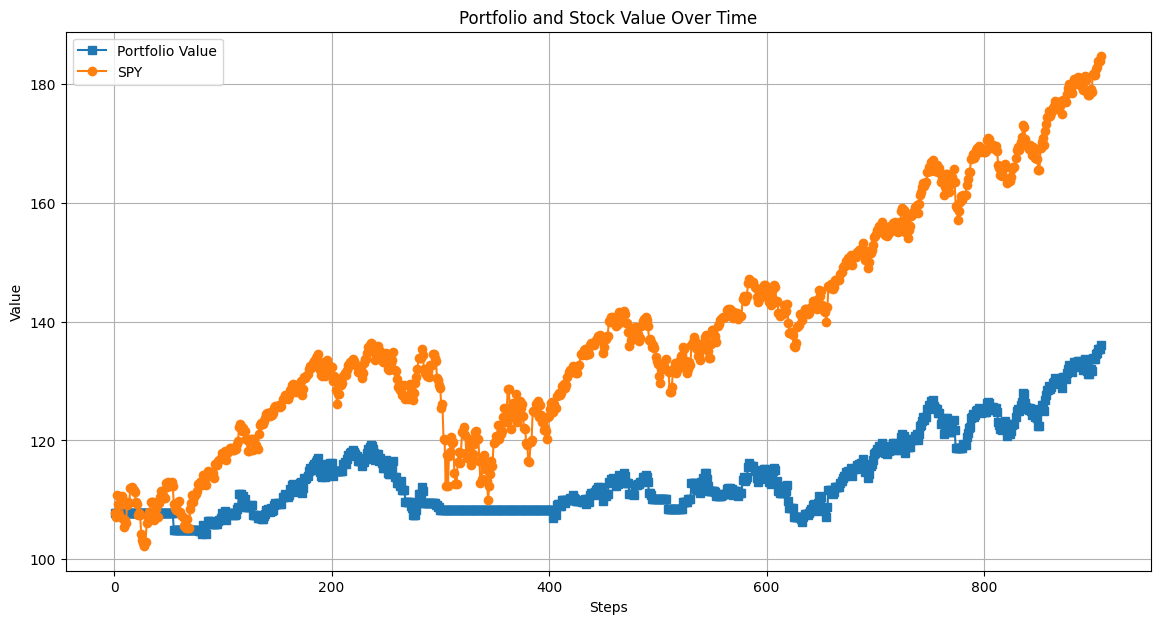

Seuil optimal: 0.024530585179531553


In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Fonction de trading
def trading_strategy_with_volatility(data, threshold, initial_money=0, initial_stocks=1):
    prices=data['Close']
    volatilities=data['Volatility']
    money = initial_money
    stocks = initial_stocks
    history = []

    for price, vol in zip(prices, volatilities):
        if vol < threshold:
            # Acheter des actions si nous avons de l'argent
            if money > 0:
                stocks += money / price
                money = 0
        else:
            # Vendre des actions si nous en détenons
            if stocks > 0:
                money += stocks * price
                stocks = 0
        portfolio_value = money + stocks * price
        history.append((money, stocks, portfolio_value, vol))
    
    return history


threshold = np.mean(np.array(data_spy['Volatility']))
print(threshold)

# Exécuter la stratégie
history = trading_strategy_with_volatility(data_spy, threshold)

# Afficher les résultats
for i, (money, stocks, portfolio_value, vol) in enumerate(history):
    print(f"Step {i+1}: Money = {money:.2f}, Stocks = {stocks:.2f}, Portfolio Value = {portfolio_value:.2f}, Volatility = {vol:.2f}")

# Extraire les valeurs pour le tracé
steps = list(range(1, len(history) + 1))
money_values = [h[0] for h in history]
stock_values = [h[1] * np.array(data_spy['Volatility'])[i] for i, h in enumerate(history)]
portfolio_values = [h[2] for h in history]
spy_value=np.array(data_spy['Close'])
print(spy_value)

# Tracer les valeurs de portefeuille et des actions en fonction du temps
plt.figure(figsize=(14, 7))

#plt.plot(steps, money_values, label='Money', marker='o')
#plt.plot(steps, stock_values, label='Stock Value', marker='x')
plt.plot(steps, portfolio_values, label='Portfolio Value', marker='s')
plt.plot(steps, spy_value, label='SPY', marker='o')

plt.xlabel('Steps')
plt.ylabel('Value')
plt.title('Portfolio and Stock Value Over Time')
plt.legend()
plt.grid(True)
plt.show()






          


0.0019813906806561074
Seuil optimal: 0.024530585179531553
Step 1: Money = 0.00, Stocks = 1.00, Portfolio Value = 107.82, Volatility = 0.01
Step 2: Money = 0.00, Stocks = 1.00, Portfolio Value = 107.17, Volatility = 0.02
Step 3: Money = 0.00, Stocks = 1.00, Portfolio Value = 110.76, Volatility = 0.02
Step 4: Money = 0.00, Stocks = 1.00, Portfolio Value = 109.37, Volatility = 0.02
Step 5: Money = 0.00, Stocks = 1.00, Portfolio Value = 107.53, Volatility = 0.01
Step 6: Money = 0.00, Stocks = 1.00, Portfolio Value = 110.33, Volatility = 0.01
Step 7: Money = 0.00, Stocks = 1.00, Portfolio Value = 110.71, Volatility = 0.01
Step 8: Money = 0.00, Stocks = 1.00, Portfolio Value = 106.82, Volatility = 0.01
Step 9: Money = 0.00, Stocks = 1.00, Portfolio Value = 105.49, Volatility = 0.01
Step 10: Money = 0.00, Stocks = 1.00, Portfolio Value = 106.62, Volatility = 0.01
Step 11: Money = 0.00, Stocks = 1.00, Portfolio Value = 106.05, Volatility = 0.01
Step 12: Money = 0.00, Stocks = 1.00, Portfolio V

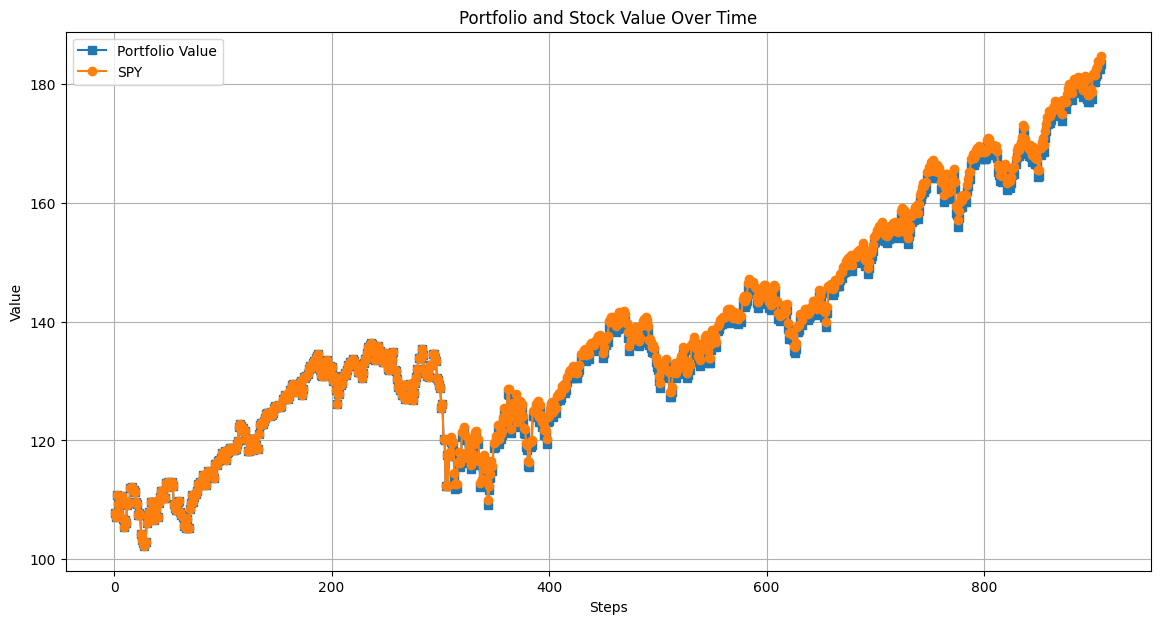

In [71]:
print(np.min(data_spy['Volatility']))
theresolds=thresholds = np.linspace(np.min(data_spy['Volatility']), np.max(data_spy['Volatility']), 100)
def evaluate_threshold(data, threshold):
    history = trading_strategy_with_volatility(data, threshold)
    final_portfolio_value = history[-1][2]  # Valeur finale du portefeuille
    return final_portfolio_value
performances = [evaluate_threshold(data_spy, t) for t in thresholds]
optimal_threshold = thresholds[np.argmax(performances)]
print(f"Seuil optimal: {optimal_threshold}")

history = trading_strategy_with_volatility(data_spy,optimal_threshold)

# Afficher les résultats
for i, (money, stocks, portfolio_value, vol) in enumerate(history):
    print(f"Step {i+1}: Money = {money:.2f}, Stocks = {stocks:.2f}, Portfolio Value = {portfolio_value:.2f}, Volatility = {vol:.2f}")

# Extraire les valeurs pour le tracé
steps = list(range(1, len(history) + 1))
money_values = [h[0] for h in history]
stock_values = [h[1] * np.array(data_spy['Volatility'])[i] for i, h in enumerate(history)]
portfolio_values = [h[2] for h in history]
spy_value=np.array(data_spy['Close'])
print(spy_value)

# Tracer les valeurs de portefeuille et des actions en fonction du temps
plt.figure(figsize=(14, 7))

#plt.plot(steps, money_values, label='Money', marker='o')
#plt.plot(steps, stock_values, label='Stock Value', marker='x')
plt.plot(steps, portfolio_values, label='Portfolio Value', marker='s')
plt.plot(steps, spy_value, label='SPY', marker='o')

plt.xlabel('Steps')
plt.ylabel('Value')
plt.title('Portfolio and Stock Value Over Time')
plt.legend()
plt.grid(True)
plt.show()


Low Threshold: 0.0052670499153789465, High Threshold: 0.008581675398210337
Step 1: Money = 107.82, Stocks = 0.00, Portfolio Value = 107.82, Volatility = 0.01
Step 2: Money = 107.82, Stocks = 0.00, Portfolio Value = 107.82, Volatility = 0.02
Step 3: Money = 107.82, Stocks = 0.00, Portfolio Value = 107.82, Volatility = 0.02
Step 4: Money = 107.82, Stocks = 0.00, Portfolio Value = 107.82, Volatility = 0.02
Step 5: Money = 107.82, Stocks = 0.00, Portfolio Value = 107.82, Volatility = 0.01
Step 6: Money = 107.82, Stocks = 0.00, Portfolio Value = 107.82, Volatility = 0.01
Step 7: Money = 107.82, Stocks = 0.00, Portfolio Value = 107.82, Volatility = 0.01
Step 8: Money = 107.82, Stocks = 0.00, Portfolio Value = 107.82, Volatility = 0.01
Step 9: Money = 107.82, Stocks = 0.00, Portfolio Value = 107.82, Volatility = 0.01
Step 10: Money = 107.82, Stocks = 0.00, Portfolio Value = 107.82, Volatility = 0.01
Step 11: Money = 107.82, Stocks = 0.00, Portfolio Value = 107.82, Volatility = 0.01
Step 12: M

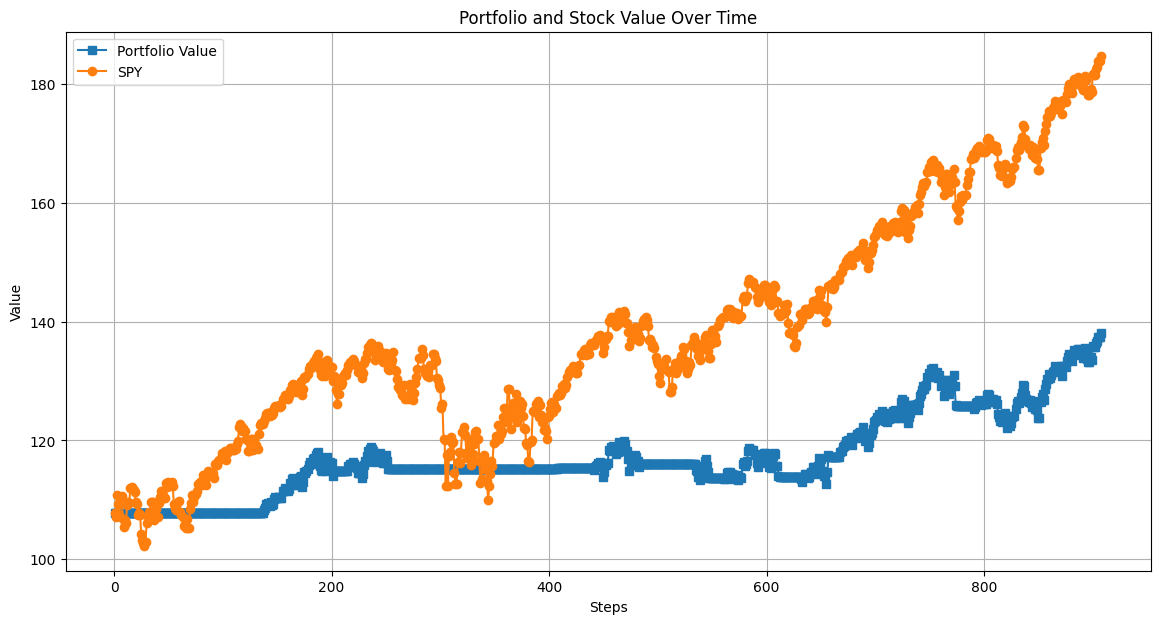

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Fonction de trading améliorée
def trading_strategy_with_volatility(data, low_threshold, high_threshold, initial_money=0, initial_stocks=1):
    prices = data['Close']
    volatilities = data['Volatility']
    money = initial_money
    stocks = initial_stocks
    history = []
    transaction_fee = 0.00  # Exemple de frais de transaction de 1%

    for price, vol in zip(prices, volatilities):
        if vol < low_threshold:
            # Acheter des actions si nous avons de l'argent
            if money > 0:
                amount_to_invest = money * (1 - transaction_fee)
                stocks += amount_to_invest / price
                money = 0
        elif vol > high_threshold:
            # Vendre des actions si nous en détenons
            if stocks > 0:
                amount_to_sell = stocks * price * (1 - transaction_fee)
                money += amount_to_sell
                stocks = 0
        portfolio_value = money + stocks * price
        history.append((money, stocks, portfolio_value, vol))
    
    return history

# Déterminer les seuils
low_threshold = np.percentile(np.array(data_spy['Volatility']), 25)
high_threshold = np.percentile(np.array(data_spy['Volatility']), 75)
print(f"Low Threshold: {low_threshold}, High Threshold: {high_threshold}")

# Exécuter la stratégie
history = trading_strategy_with_volatility(data_spy, low_threshold, high_threshold)

# Afficher les résultats
for i, (money, stocks, portfolio_value, vol) in enumerate(history):
    print(f"Step {i+1}: Money = {money:.2f}, Stocks = {stocks:.2f}, Portfolio Value = {portfolio_value:.2f}, Volatility = {vol:.2f}")

# Extraire les valeurs pour le tracé
steps = list(range(1, len(history) + 1))
money_values = [h[0] for h in history]
stock_values = [h[1] * np.array(data_spy['Close'])[i] for i, h in enumerate(history)]
portfolio_values = [h[2] for h in history]
spy_value = np.array(data_spy['Close'])
print(spy_value)

# Tracer les valeurs de portefeuille et des actions en fonction du temps
plt.figure(figsize=(14, 7))

plt.plot(steps, portfolio_values, label='Portfolio Value', marker='s')
plt.plot(steps, spy_value, label='SPY', marker='o')

plt.xlabel('Steps')
plt.ylabel('Value')
plt.title('Portfolio and Stock Value Over Time')
plt.legend()
plt.grid(True)
plt.show()


Low Threshold: 0.0052670499153789465, High Threshold: 0.008581675398210337


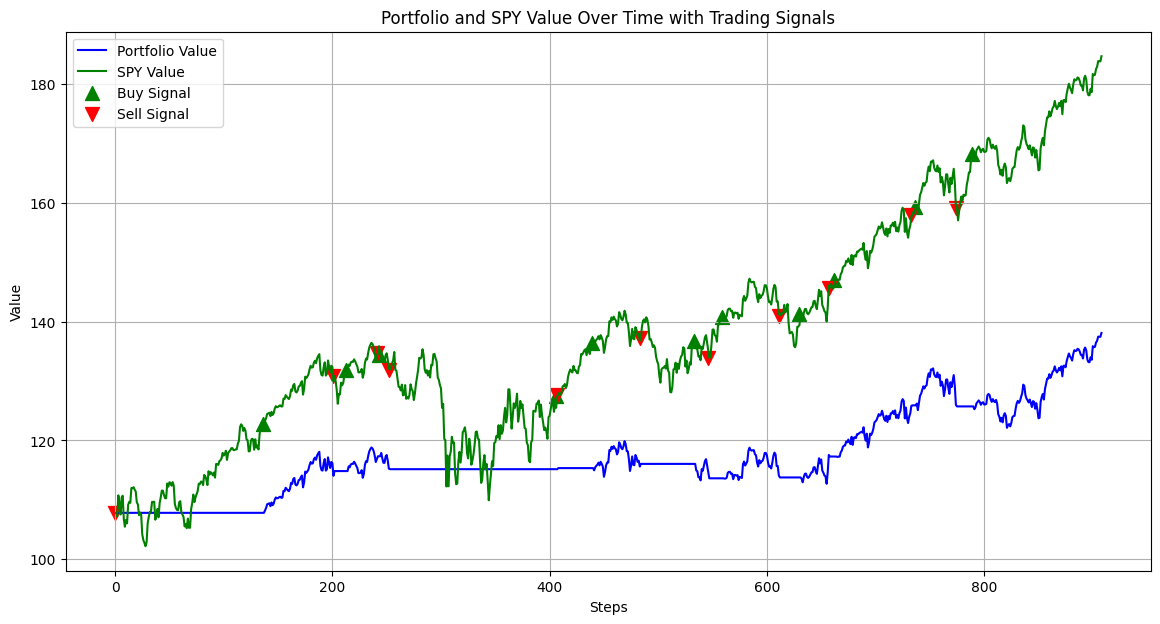

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# Fonction de trading améliorée
def trading_strategy_with_volatility(data, low_threshold, high_threshold, initial_money=0, initial_stocks=1):
    prices = data['Close']
    volatilities = data['Volatility']
    money = initial_money
    stocks = initial_stocks
    history = []
    transaction_fee = 0.00 # Exemple de frais de transaction de 1%
    buy_signals = []
    sell_signals = []

    for i, (price, vol) in enumerate(zip(prices, volatilities)):
        if vol < low_threshold:
            # Acheter des actions si nous avons de l'argent
            if money > 0:
                amount_to_invest = money * (1 - transaction_fee)
                stocks += amount_to_invest / price
                money = 0
                buy_signals.append((i, price))
        elif vol > high_threshold:
            # Vendre des actions si nous en détenons
            if stocks > 0:
                amount_to_sell = stocks * price * (1 - transaction_fee)
                money += amount_to_sell
                stocks = 0
                sell_signals.append((i, price))
        portfolio_value = money + stocks * price
        history.append((money, stocks, portfolio_value, vol))
    
    return history, buy_signals, sell_signals

# Déterminer les seuils
low_threshold = np.percentile(np.array(data_spy['Volatility']), 25)
high_threshold = np.percentile(np.array(data_spy['Volatility']), 75)
print(f"Low Threshold: {low_threshold}, High Threshold: {high_threshold}")

# Exécuter la stratégie
history, buy_signals, sell_signals = trading_strategy_with_volatility(data_spy, low_threshold, high_threshold)

# Extraire les valeurs pour le tracé
steps = list(range(1, len(history) + 1))
money_values = [h[0] for h in history]
stock_values = [h[1] * np.array(data_spy['Close'])[i] for i, h in enumerate(history)]
portfolio_values = [h[2] for h in history]
spy_values = np.array(data_spy['Close'])

# Tracer les valeurs de portefeuille et des actions en fonction du temps
plt.figure(figsize=(14, 7))

# Tracé des valeurs de portefeuille et SPY
plt.plot(steps, portfolio_values, label='Portfolio Value', color='b')
plt.plot(steps, spy_values, label='SPY Value', color='g')

# Ajouter des triangles pour les signaux d'achat et de vente
buy_steps, buy_prices = zip(*buy_signals) if buy_signals else ([], [])
sell_steps, sell_prices = zip(*sell_signals) if sell_signals else ([], [])
plt.scatter(buy_steps, buy_prices, color='green', marker='^', label='Buy Signal', s=100)
plt.scatter(sell_steps, sell_prices, color='red', marker='v', label='Sell Signal', s=100)

# Ajouter des titres et des étiquettes
plt.xlabel('Steps')
plt.ylabel('Value')
plt.title('Portfolio and SPY Value Over Time with Trading Signals')

# Ajouter une légende et une grille
plt.legend()
plt.grid(True)

# Afficher le graphique
plt.show()


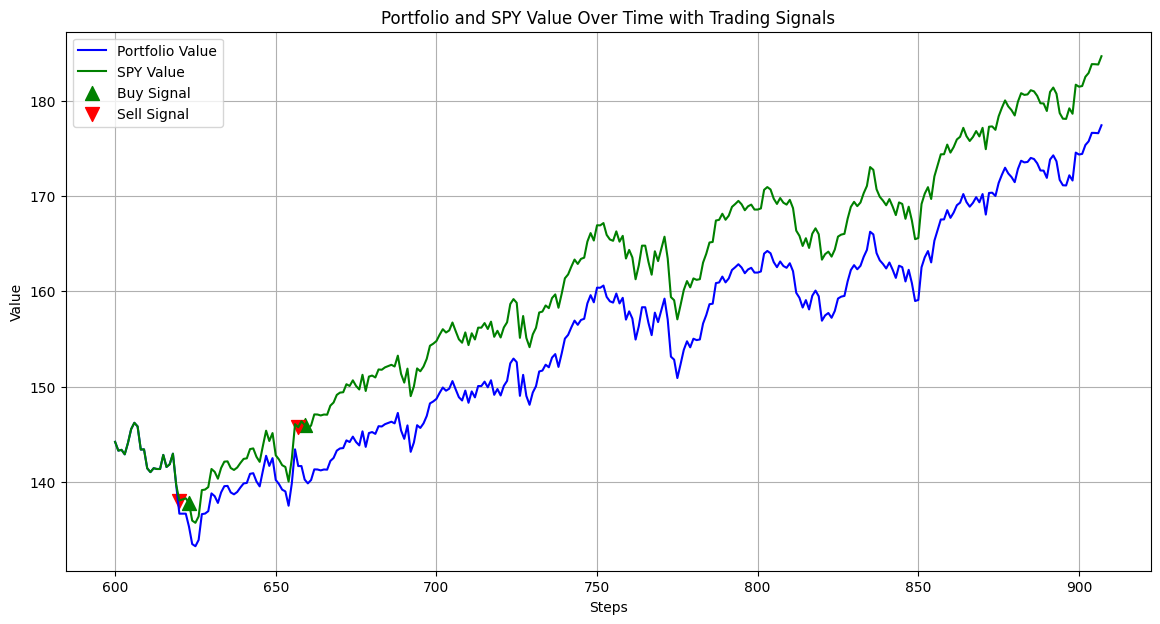

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

# Fonction de trading améliorée avec optimisation par fenêtre glissante
def trading_strategy_with_rolling_window(data, window_size, initial_money=0, initial_stocks=1):
    prices = data['Close']
    volatilities = data['Volatility']
    money = initial_money
    stocks = initial_stocks
    history = []
    transaction_fee = 0.01  # Exemple de frais de transaction de 1%
    buy_signals = []
    sell_signals = []

    for i in range(window_size, len(data)):
        # Déterminer la fenêtre de données actuelle
        window_data = data.iloc[i-window_size:i]
        
        # Optimiser les seuils pour la fenêtre actuelle
        low_threshold, high_threshold = optimize_thresholds(window_data)
        
        price = prices.iloc[i]
        vol = volatilities.iloc[i]
        
        if vol < low_threshold:
            # Acheter des actions si nous avons de l'argent
            if money > 0:
                amount_to_invest = money * (1 - transaction_fee)
                stocks += amount_to_invest / price
                money = 0
                buy_signals.append((i, price))
        elif vol > high_threshold:
            # Vendre des actions si nous en détenons
            if stocks > 0:
                amount_to_sell = stocks * price * (1 - transaction_fee)
                money += amount_to_sell
                stocks = 0
                sell_signals.append((i, price))
        portfolio_value = money + stocks * price
        history.append((money, stocks, portfolio_value, vol))
    
    return history, buy_signals, sell_signals

# Déterminer les seuils optimaux par recherche par grille
def optimize_thresholds(data):
    best_thresholds = None
    best_portfolio_value = -np.inf
    low_thresholds = np.percentile(np.array(data['Volatility']), np.arange(10, 50, 5))
    high_thresholds = np.percentile(np.array(data['Volatility']), np.arange(50, 90, 5))
    
    for low_threshold, high_threshold in product(low_thresholds, high_thresholds):
        history, _, _ = trading_strategy_with_volatility(data, low_threshold, high_threshold)
        final_portfolio_value = history[-1][2]
        
        if final_portfolio_value > best_portfolio_value:
            best_portfolio_value = final_portfolio_value
            best_thresholds = (low_threshold, high_threshold)
    
    return best_thresholds

# Convertir les données en DataFrame pandas si nécessaire
data_spy = pd.DataFrame(data_spy)

# Définir la taille de la fenêtre glissante
window_size = 600 # Par exemple, une année de trading (252 jours)

# Exécuter la stratégie avec optimisation par fenêtre glissante
history, buy_signals, sell_signals = trading_strategy_with_rolling_window(data_spy, window_size)

# Extraire les valeurs pour le tracé
steps = list(range(window_size, len(data_spy)))
money_values = [h[0] for h in history]
stock_values = [h[1] * np.array(data_spy['Close'])[i] for i, h in enumerate(history)]
portfolio_values = [h[2] for h in history]
spy_values = np.array(data_spy['Close'])[window_size:]

# Tracer les valeurs de portefeuille et des actions en fonction du temps
plt.figure(figsize=(14, 7))

# Tracé des valeurs de portefeuille et SPY
plt.plot(steps, portfolio_values, label='Portfolio Value', color='b')
plt.plot(steps, spy_values, label='SPY Value', color='g')

# Ajouter des triangles pour les signaux d'achat et de vente
if buy_signals:
    buy_steps, buy_prices = zip(*buy_signals)
else:
    buy_steps, buy_prices = [], []

if sell_signals:
    sell_steps, sell_prices = zip(*sell_signals)
else:
    sell_steps, sell_prices = [], []

plt.scatter(buy_steps, buy_prices, color='green', marker='^', label='Buy Signal', s=100)
plt.scatter(sell_steps, sell_prices, color='red', marker='v', label='Sell Signal', s=100)

# Ajouter des titres et des étiquettes
plt.xlabel('Steps')
plt.ylabel('Value')
plt.title('Portfolio and SPY Value Over Time with Trading Signals')

# Ajouter une légende et une grille
plt.legend()
plt.grid(True)

# Afficher le graphique
plt.show()


Window Size: 50, Final Portfolio Value: 124.40938454542395
Window Size: 100, Final Portfolio Value: 136.64527303705628
Window Size: 150, Final Portfolio Value: 141.66264149331235
Window Size: 200, Final Portfolio Value: 148.6573334199277
Window Size: 250, Final Portfolio Value: 135.60703265747776
Window Size: 300, Final Portfolio Value: 137.1166629577181
Window Size: 350, Final Portfolio Value: 147.6614744884617
Window Size: 400, Final Portfolio Value: 155.45824167770982
Window Size: 450, Final Portfolio Value: 167.0709054059675


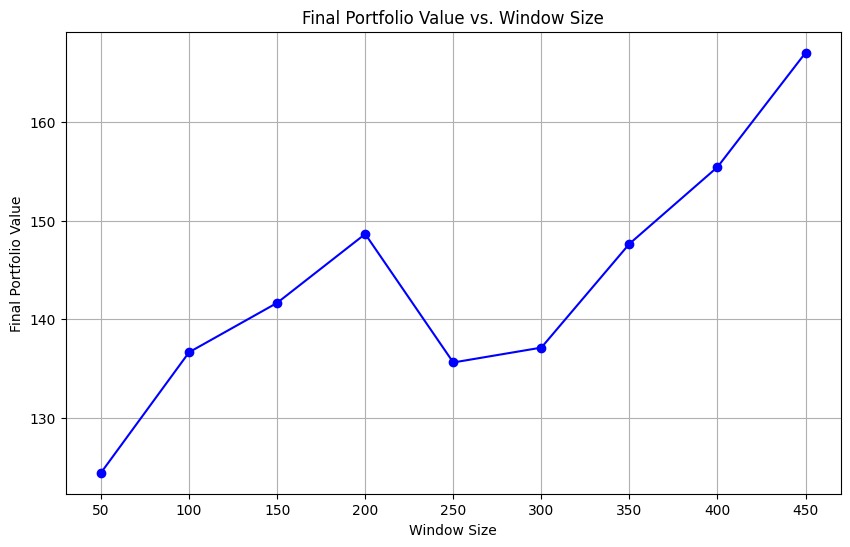

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

# Fonction de trading améliorée avec optimisation par fenêtre glissante
def trading_strategy_with_rolling_window(data, window_size, initial_money=0, initial_stocks=1):
    prices = data['Close']
    volatilities = data['Volatility']
    money = initial_money
    stocks = initial_stocks
    history = []
    transaction_fee = 0.00  # Exemple de frais de transaction de 1%
    buy_signals = []
    sell_signals = []

    for i in range(window_size, len(data)):
        # Déterminer la fenêtre de données actuelle
        window_data = data.iloc[i-window_size:i]
        
        # Optimiser les seuils pour la fenêtre actuelle
        low_threshold, high_threshold = optimize_thresholds(window_data)
        
        price = prices.iloc[i]
        vol = volatilities.iloc[i]
        
        if vol < low_threshold:
            # Acheter des actions si nous avons de l'argent
            if money > 0:
                amount_to_invest = money * (1 - transaction_fee)
                stocks += amount_to_invest / price
                money = 0
                buy_signals.append((i, price))
        elif vol > high_threshold:
            # Vendre des actions si nous en détenons
            if stocks > 0:
                amount_to_sell = stocks * price * (1 - transaction_fee)
                money += amount_to_sell
                stocks = 0
                sell_signals.append((i, price))
        portfolio_value = money + stocks * price
        history.append((money, stocks, portfolio_value, vol))
    
    return history, buy_signals, sell_signals

# Déterminer les seuils optimaux par recherche par grille
def optimize_thresholds(data):
    best_thresholds = None
    best_portfolio_value = -np.inf
    low_thresholds = np.percentile(np.array(data['Volatility']), np.arange(10, 50, 5))
    high_thresholds = np.percentile(np.array(data['Volatility']), np.arange(50, 90, 5))
    
    for low_threshold, high_threshold in product(low_thresholds, high_thresholds):
        history, _, _ = trading_strategy_with_volatility(data, low_threshold, high_threshold)
        final_portfolio_value = history[-1][2]
        
        if final_portfolio_value > best_portfolio_value:
            best_portfolio_value = final_portfolio_value
            best_thresholds = (low_threshold, high_threshold)
    
    return best_thresholds

# Convertir les données en DataFrame pandas si nécessaire
data_spy = pd.DataFrame(data_spy)

# Définir différentes tailles de fenêtre à tester
window_sizes = np.arange(50, 500, 50)

# Stocker les valeurs finales du portefeuille pour chaque taille de fenêtre
final_portfolio_values = []

# Exécuter la stratégie pour chaque taille de fenêtre et stocker les résultats
for window_size in window_sizes:
    history, _, _ = trading_strategy_with_rolling_window(data_spy, window_size)
    final_portfolio_value = history[-1][2]
    final_portfolio_values.append(final_portfolio_value)
    print(f"Window Size: {window_size}, Final Portfolio Value: {final_portfolio_value}")

# Tracer la valeur finale du portefeuille en fonction de la taille de la fenêtre
plt.figure(figsize=(10, 6))
plt.plot(window_sizes, final_portfolio_values, marker='o', linestyle='-', color='b')
plt.xlabel('Window Size')
plt.ylabel('Final Portfolio Value')
plt.title('Final Portfolio Value vs. Window Size')
plt.grid(True)
plt.show()


Window Size: 50, Final Portfolio Value: 106.93592703849602
Window Size: 100, Final Portfolio Value: 105.36083163300734
Window Size: 150, Final Portfolio Value: 141.76043064801215
Window Size: 200, Final Portfolio Value: 156.51551763604715
Window Size: 250, Final Portfolio Value: 159.4942715196016
Window Size: 300, Final Portfolio Value: 156.7075822126805
Window Size: 350, Final Portfolio Value: 158.6024682766164
Window Size: 400, Final Portfolio Value: 169.5945762646033
Window Size: 450, Final Portfolio Value: 184.69000244140625


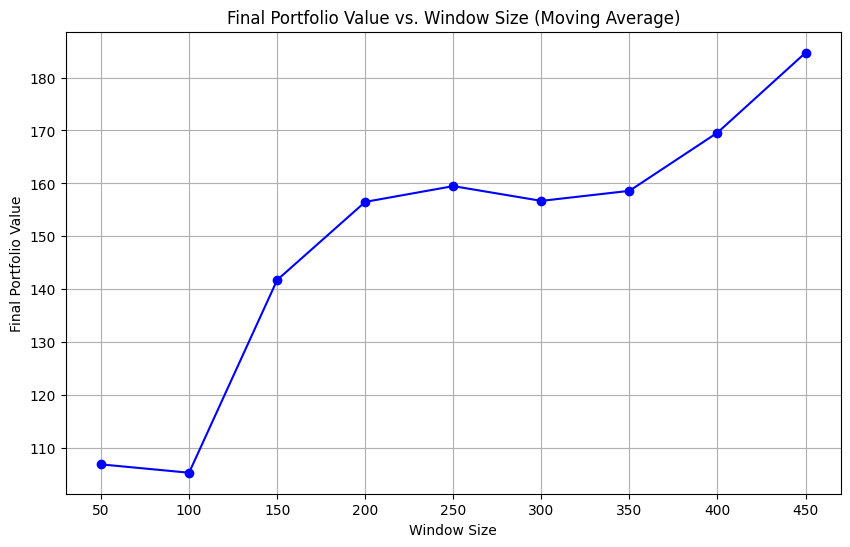

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

def calculate_sma(data, window):
    return data.rolling(window=window).mean()

# Calcul des indicateurs techniques
def calculate_technical_indicators(data, window_size):
    data['SMA'] = calculate_sma(data['Close'], window_size)
    return data

# Fonction de trading améliorée avec moyennes mobiles et volatilité
def trading_strategy_with_moving_average(data, window_size, initial_money=0, initial_stocks=1):
    data = calculate_technical_indicators(data, window_size)
    prices = data['Close']
    volatilities = data['Volatility']
    money = initial_money
    stocks = initial_stocks
    history = []
    transaction_fee = 0.01  # Exemple de frais de transaction de 1%
    buy_signals = []
    sell_signals = []

    for i in range(window_size, len(data)):
        window_data = data.iloc[i-window_size:i]
        low_threshold, high_threshold = optimize_thresholds(window_data)
        
        price = prices.iloc[i]
        vol = volatilities.iloc[i]
        sma = data['SMA'].iloc[i]
        
        if price > sma and vol < low_threshold:
            if money > 0:
                amount_to_invest = money * (1 - transaction_fee)
                stocks += amount_to_invest / price
                money = 0
                buy_signals.append((i, price))
        elif price < sma and vol > high_threshold:
            if stocks > 0:
                amount_to_sell = stocks * price * (1 - transaction_fee)
                money += amount_to_sell
                stocks = 0
                sell_signals.append((i, price))
        portfolio_value = money + stocks * price
        history.append((money, stocks, portfolio_value, vol))
    
    return history, buy_signals, sell_signals

# Déterminer les seuils optimaux par recherche par grille
def optimize_thresholds(data):
    best_thresholds = None
    best_portfolio_value = -np.inf
    low_thresholds = np.percentile(np.array(data['Volatility']), np.arange(10, 50, 5))
    high_thresholds = np.percentile(np.array(data['Volatility']), np.arange(50, 90, 5))
    
    for low_threshold, high_threshold in product(low_thresholds, high_thresholds):
        history, _, _ = trading_strategy_with_volatility(data, low_threshold, high_threshold)
        final_portfolio_value = history[-1][2]
        
        if final_portfolio_value > best_portfolio_value:
            best_portfolio_value = final_portfolio_value
            best_thresholds = (low_threshold, high_threshold)
    
    return best_thresholds

# Convertir les données en DataFrame pandas si nécessaire
data_spy = pd.DataFrame(data_spy)

# Définir différentes tailles de fenêtre à tester
window_sizes = np.arange(50, 500, 50)

# Stocker les valeurs finales du portefeuille pour chaque taille de fenêtre
final_portfolio_values = []

# Exécuter la stratégie pour chaque taille de fenêtre et stocker les résultats
for window_size in window_sizes:
    history, _, _ = trading_strategy_with_moving_average(data_spy, window_size)
    final_portfolio_value = history[-1][2]
    final_portfolio_values.append(final_portfolio_value)
    print(f"Window Size: {window_size}, Final Portfolio Value: {final_portfolio_value}")

# Tracer la valeur finale du portefeuille en fonction de la taille de la fenêtre
plt.figure(figsize=(10, 6))
plt.plot(window_sizes, final_portfolio_values, marker='o', linestyle='-', color='b')
plt.xlabel('Window Size')
plt.ylabel('Final Portfolio Value')
plt.title('Final Portfolio Value vs. Window Size (Moving Average)')
plt.grid(True)
plt.show()


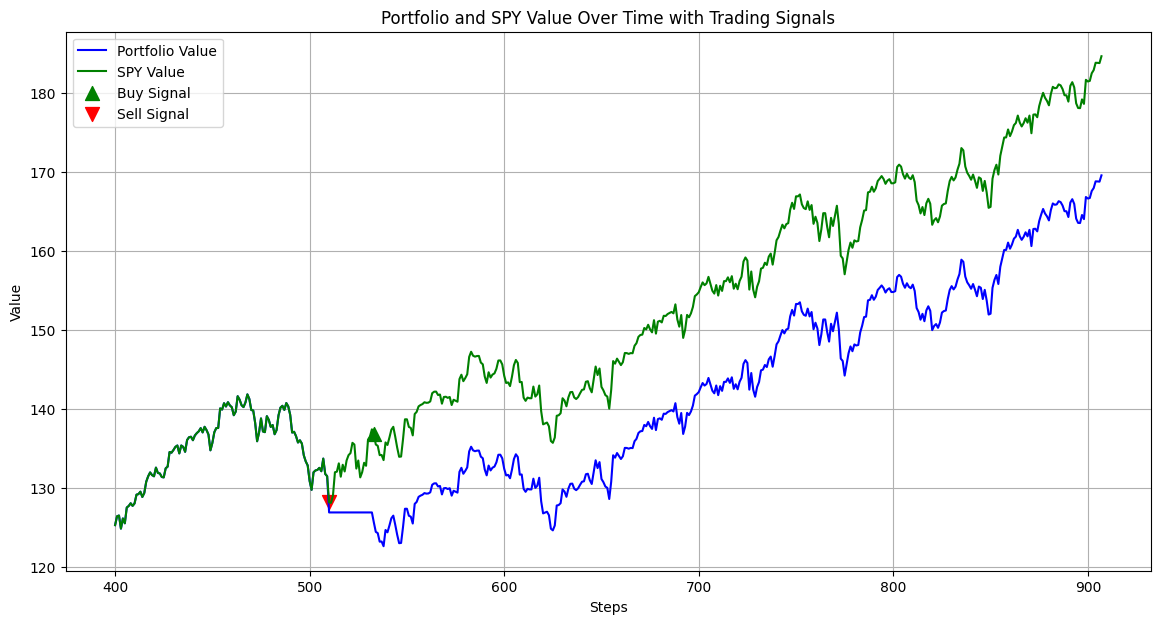

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

# Calcul des indicateurs techniques
def calculate_technical_indicators(data, window_size):
    data['SMA'] = calculate_sma(data['Close'], window_size)
    return data

# Fonction de trading améliorée avec moyennes mobiles et volatilité
def trading_strategy_with_moving_average(data, window_size, initial_money=0, initial_stocks=1):
    data = calculate_technical_indicators(data, window_size)
    prices = data['Close']
    volatilities = data['Volatility']
    money = initial_money
    stocks = initial_stocks
    history = []
    transaction_fee = 0.01  # Exemple de frais de transaction de 1%
    buy_signals = []
    sell_signals = []

    for i in range(window_size, len(data)):
        window_data = data.iloc[i-window_size:i]
        low_threshold, high_threshold = optimize_thresholds(window_data)
        
        price = prices.iloc[i]
        vol = volatilities.iloc[i]
        sma = data['SMA'].iloc[i]
        
        if price > sma and vol < low_threshold:
            if money > 0:
                amount_to_invest = money * (1 - transaction_fee)
                stocks += amount_to_invest / price
                money = 0
                buy_signals.append((i, price))
        elif price < sma and vol > high_threshold:
            if stocks > 0:
                amount_to_sell = stocks * price * (1 - transaction_fee)
                money += amount_to_sell
                stocks = 0
                sell_signals.append((i, price))
        portfolio_value = money + stocks * price
        history.append((money, stocks, portfolio_value, vol))
    
    return history, buy_signals, sell_signals

# Déterminer les seuils optimaux par recherche par grille
def optimize_thresholds(data):
    best_thresholds = None
    best_portfolio_value = -np.inf
    low_thresholds = np.percentile(np.array(data['Volatility']), np.arange(10, 50, 5))
    high_thresholds = np.percentile(np.array(data['Volatility']), np.arange(50, 90, 5))
    
    for low_threshold, high_threshold in product(low_thresholds, high_thresholds):
        history, _, _ = trading_strategy_with_volatility(data, low_threshold, high_threshold)
        final_portfolio_value = history[-1][2]
        
        if final_portfolio_value > best_portfolio_value:
            best_portfolio_value = final_portfolio_value
            best_thresholds = (low_threshold, high_threshold)
    
    return best_thresholds

# Convertir les données en DataFrame pandas si nécessaire
data_spy = pd.DataFrame(data_spy)

# Définir la taille de la fenêtre fixe
window_size = 400  # Par exemple, une année de trading (252 jours)

# Exécuter la stratégie avec la fenêtre fixe
history, buy_signals, sell_signals = trading_strategy_with_moving_average(data_spy, window_size)

# Extraire les valeurs pour le tracé
steps = list(range(window_size, len(data_spy)))
money_values = [h[0] for h in history]
stock_values = [h[1] * np.array(data_spy['Close'])[i] for i, h in enumerate(history)]
portfolio_values = [h[2] for h in history]
spy_values = np.array(data_spy['Close'])[window_size:]

# Tracer les valeurs de portefeuille et des actions en fonction du temps
plt.figure(figsize=(14, 7))

# Tracé des valeurs de portefeuille et SPY
plt.plot(steps, portfolio_values, label='Portfolio Value', color='b')
plt.plot(steps, spy_values, label='SPY Value', color='g')

# Ajouter des triangles pour les signaux d'achat et de vente
if buy_signals:
    buy_steps, buy_prices = zip(*buy_signals)
else:
    buy_steps, buy_prices = [], []

if sell_signals:
    sell_steps, sell_prices = zip(*sell_signals)
else:
    sell_steps, sell_prices = [], []

plt.scatter(buy_steps, buy_prices, color='green', marker='^', label='Buy Signal', s=100)
plt.scatter(sell_steps, sell_prices, color='red', marker='v', label='Sell Signal', s=100)

# Ajouter des titres et des étiquettes
plt.xlabel('Steps')
plt.ylabel('Value')
plt.title('Portfolio and SPY Value Over Time with Trading Signals')

# Ajouter une légende et une grille
plt.legend()
plt.grid(True)

# Afficher le graphique
plt.show()


In [87]:
def calculate_rsi(data, window):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

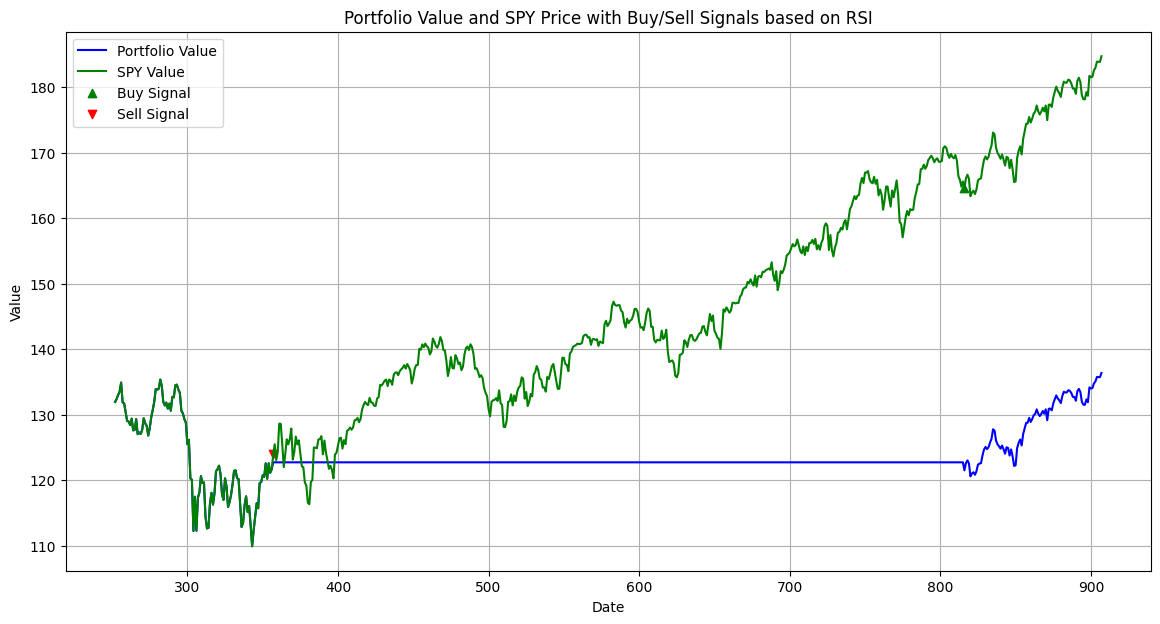

{'Sharpe Ratio': 0.165259389816335,
 'Max Drawdown': 0.18786938675021753,
 'Total Profit': -40.589996337890625,
 'Cumulative P&L': 1.033467265053893,
 'Order Book':    Date  Type       Price  Units
 0  3427   Buy  164.559998      1
 1  2968  Sell  123.970001      1}

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

# Calcul du RSI
def calculate_rsi(data, window):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Fonction de trading améliorée avec RSI et volatilité
def trading_strategy_with_rsi(data, window_size, initial_money=0, initial_stocks=1, rsi_period=14, rsi_overbought=70, rsi_oversold=30):
    data['RSI'] = calculate_rsi(data['Close'], rsi_period)
    prices = data['Close']
    volatilities = data['Volatility']
    money = initial_money
    stocks = initial_stocks
    history = []
    transaction_fee = 0.01  # Exemple de frais de transaction de 1%
    buy_signals = []
    sell_signals = []

    for i in range(window_size, len(data)):
        window_data = data.iloc[i-window_size:i]
        low_threshold, high_threshold = optimize_thresholds(window_data)
        
        price = prices.iloc[i]
        vol = volatilities.iloc[i]
        rsi = data['RSI'].iloc[i]
        
        if rsi < rsi_oversold and vol < low_threshold:
            if money > 0:
                amount_to_invest = money * (1 - transaction_fee)
                stocks += amount_to_invest / price
                money = 0
                buy_signals.append((i, price))
        elif rsi > rsi_overbought and vol > high_threshold:
            if stocks > 0:
                amount_to_sell = stocks * price * (1 - transaction_fee)
                money += amount_to_sell
                stocks = 0
                sell_signals.append((i, price))
        portfolio_value = money + stocks * price
        history.append((money, stocks, portfolio_value, vol))
    
    return history, buy_signals, sell_signals

# Déterminer les seuils optimaux par recherche par grille
def optimize_thresholds(data):
    best_thresholds = None
    best_portfolio_value = -np.inf
    low_thresholds = np.percentile(np.array(data['Volatility']), np.arange(10, 50, 5))
    high_thresholds = np.percentile(np.array(data['Volatility']), np.arange(50, 90, 5))
    
    for low_threshold, high_threshold in product(low_thresholds, high_thresholds):
        history, _, _ = trading_strategy_with_volatility(data, low_threshold, high_threshold)
        final_portfolio_value = history[-1][2]
        
        if final_portfolio_value > best_portfolio_value:
            best_portfolio_value = final_portfolio_value
            best_thresholds = (low_threshold, high_threshold)
    
    return best_thresholds

# Convertir les données en DataFrame pandas si nécessaire
data_spy = pd.DataFrame(data_spy)

# Définir la taille de la fenêtre fixe
window_size = 252  # Par exemple, une année de trading (252 jours)

# Exécuter la stratégie avec la fenêtre fixe
history, buy_signals, sell_signals = trading_strategy_with_rsi(data_spy, window_size)

# Extraire les valeurs pour le tracé
steps = list(range(window_size, len(data_spy)))
money_values = [h[0] for h in history]
stock_values = [h[1] * np.array(data_spy['Close'])[i] for i, h in enumerate(history)]
portfolio_values = [h[2] for h in history]
spy_values = np.array(data_spy['Close'])[window_size:]

# Créer le DataFrame des résultats
results = pd.DataFrame({
    'Money': money_values,
    'Stocks': stock_values,
    'Portfolio Value': portfolio_values,
    'Volatility': [h[3] for h in history]
})

# Calcul du P&L quotidien et cumulatif
results['Return'] = results['Portfolio Value'].pct_change()
results['PnL'] = results['Return'].shift(-1).fillna(0)
results['Cumulative PnL'] = (1 + results['PnL']).cumprod()

# Calcul du Sharpe Ratio
sharpe_ratio = results['PnL'].mean() / results['PnL'].std() * np.sqrt(252)

# Calcul du drawdown
results['Peak'] = results['Cumulative PnL'].cummax()
results['Drawdown'] = (results['Peak'] - results['Cumulative PnL']) / results['Peak']
max_drawdown = results['Drawdown'].max()

# Création du carnet d'ordre
orders = []
for i in range(len(buy_signals)):
    orders.append({'Date': data_spy.index[buy_signals[i][0]], 'Type': 'Buy', 'Price': buy_signals[i][1], 'Units': 1})
for i in range(len(sell_signals)):
    orders.append({'Date': data_spy.index[sell_signals[i][0]], 'Type': 'Sell', 'Price': sell_signals[i][1], 'Units': 1})
orders_df = pd.DataFrame(orders)

# Graphique de l'évolution du portefeuille et du prix de l'actif avec signaux d'achat et de vente
plt.figure(figsize=(14, 7))
plt.plot(steps, portfolio_values, label='Portfolio Value', color='b')
plt.plot(steps, spy_values, label='SPY Value', color='g')
plt.scatter([buy_signals[i][0] for i in range(len(buy_signals))], [buy_signals[i][1] for i in range(len(buy_signals))], label='Buy Signal', marker='^', color='green', alpha=1)
plt.scatter([sell_signals[i][0] for i in range(len(sell_signals))], [sell_signals[i][1] for i in range(len(sell_signals))], label='Sell Signal', marker='v', color='red', alpha=1)
plt.title('Portfolio Value and SPY Price with Buy/Sell Signals based on RSI')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Calcul des bénéfices totaux
buy_prices = [buy_signals[i][1] for i in range(len(buy_signals))]
sell_prices = [sell_signals[i][1] for i in range(len(sell_signals))]
num_trades = min(len(buy_prices), len(sell_prices))
profits = np.array(sell_prices[:num_trades]) - np.array(buy_prices[:num_trades])
total_profit = profits.sum()

# Retourner les résultats sous forme de dictionnaire
results_dict = {
    'Sharpe Ratio': sharpe_ratio,
    'Max Drawdown': max_drawdown,
    'Total Profit': total_profit,
    'Cumulative P&L': results['Cumulative PnL'].iloc[-1], 
    'Order Book': orders_df
}

results_dict


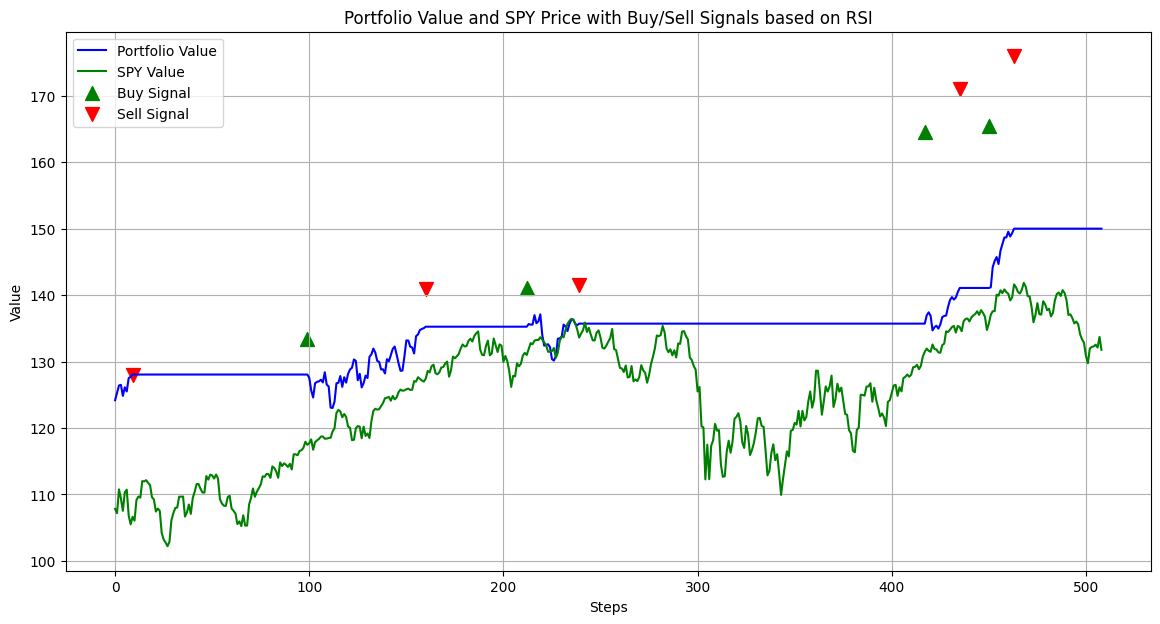

{'Sharpe Ratio': 1.3265060437521354,
 'Max Drawdown': 0.05078350185136602,
 'Total Profit': -22.949996948242188,
 'Cumulative P&L': 1.2079907672237649,
 'Order Book':    Date  Type       Price  Units
 0  2710   Buy  133.339996      1
 1  2823   Buy  141.020004      1
 2  3028   Buy  164.559998      1
 3  3061   Buy  165.479996      1
 4  2620  Sell  128.039993      1
 5  2771  Sell  140.839996      1
 6  2850  Sell  141.500000      1
 7  3046  Sell  171.070007      1
 8  3074  Sell  175.949997      1}

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calcul du RSI
def calculate_rsi(data, window):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Fonction de trading avec RSI classique
def trading_strategy_rsi(data, rsi_period=14, rsi_overbought=70, rsi_oversold=30, initial_money=0):
    data['RSI'] = calculate_rsi(data['Close'], rsi_period)
    data = data.dropna()

    money = initial_money
    stocks = 1
    portfolio_value = initial_money + stocks * data['Close'].iloc[0]
    history = []
    buy_signals = []
    sell_signals = []

    for i in range(len(data)):
        price = data['Close'].iloc[i]
        rsi = data['RSI'].iloc[i]

        if rsi < rsi_oversold and money > 0:
            # Buy signal
            stocks = money / price
            money = 0
            buy_signals.append((i, price))

        elif rsi > rsi_overbought and stocks > 0:
            # Sell signal
            money = stocks * price
            stocks = 0
            sell_signals.append((i, price))

        portfolio_value = money + stocks * price
        history.append((money, stocks, portfolio_value))

    return history, buy_signals, sell_signals

# Exécuter la stratégie
window_size = 14  # RSI period
data_spy = pd.DataFrame(data_spy)  # Assurez-vous que data_spy est un DataFrame
history, buy_signals, sell_signals = trading_strategy_rsi(data_spy, rsi_period=window_size)

# Extraire les valeurs pour le tracé
steps = range(len(history))
money_values = [h[0] for h in history]
stock_values = [h[1] * data_spy['Close'].iloc[i] for i, h in enumerate(history)]
portfolio_values = [h[2] for h in history]
spy_values = data_spy['Close'].iloc[:len(history)].values

# Graphique de l'évolution du portefeuille et du prix de l'actif avec signaux d'achat et de vente
plt.figure(figsize=(14, 7))
plt.plot(steps, portfolio_values, label='Portfolio Value', color='b')
plt.plot(steps, spy_values, label='SPY Value', color='g')
plt.scatter([buy[0] for buy in buy_signals], [buy[1] for buy in buy_signals], color='green', marker='^', label='Buy Signal', s=100)
plt.scatter([sell[0] for sell in sell_signals], [sell[1] for sell in sell_signals], color='red', marker='v', label='Sell Signal', s=100)
plt.title('Portfolio Value and SPY Price with Buy/Sell Signals based on RSI')
plt.xlabel('Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Calcul des bénéfices totaux
buy_prices = [buy[1] for buy in buy_signals]
sell_prices = [sell[1] for sell in sell_signals]
num_trades = min(len(buy_prices), len(sell_prices))
profits = np.array(sell_prices[:num_trades]) - np.array(buy_prices[:num_trades])
total_profit = profits.sum()

# Calcul du Sharpe Ratio
portfolio_returns = pd.Series(portfolio_values).pct_change().dropna()
sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)

# Calcul du drawdown
cumulative_returns = (1 + portfolio_returns).cumprod()
peak = cumulative_returns.cummax()
drawdown = (peak - cumulative_returns) / peak
max_drawdown = drawdown.max()

# Création du carnet d'ordre
orders = []
for buy in buy_signals:
    orders.append({'Date': data_spy.index[buy[0]], 'Type': 'Buy', 'Price': buy[1], 'Units': 1})
for sell in sell_signals:
    orders.append({'Date': data_spy.index[sell[0]], 'Type': 'Sell', 'Price': sell[1], 'Units': 1})
orders_df = pd.DataFrame(orders)

# Retourner les résultats sous forme de dictionnaire
results_dict = {
    'Sharpe Ratio': sharpe_ratio,
    'Max Drawdown': max_drawdown,
    'Total Profit': total_profit,
    'Cumulative P&L': cumulative_returns.iloc[-1],
    'Order Book': orders_df
}

results_dict



107.81999969482422
107.81999969482422
           Date        Open        High         Low       Close  Adj Close  \
2611 2010-05-25  105.110001  107.870003  104.379997  107.820000  82.977325   
2612 2010-05-26  108.480003  109.470001  106.849998  107.169998  82.477058   
2613 2010-05-27  109.190002  110.800003  108.779999  110.760002  85.239876   
2614 2010-05-28  110.639999  110.720001  108.849998  109.370003  84.170166   
2615 2010-06-01  108.349998  109.949997  107.370003  107.529999  82.754135   

         Volume   Returns  Volatility  SMA  RSI       ATR  
2611  396505200  0.001021    0.013375  NaN  NaN  3.490005  
2612  349719300 -0.006029    0.017338  NaN  NaN  3.055004  
2613  300870500  0.033498    0.015391  NaN  NaN  3.246671  
2614  297933500 -0.012550    0.015162  NaN  NaN  2.912504  
2615  277909400 -0.016824    0.014406  NaN  NaN  2.846002  
[107.81999969 107.16999817 110.76000214 109.37000275 107.52999878
 110.33000183 110.70999908 106.81999969 105.48999786 106.62000275
 

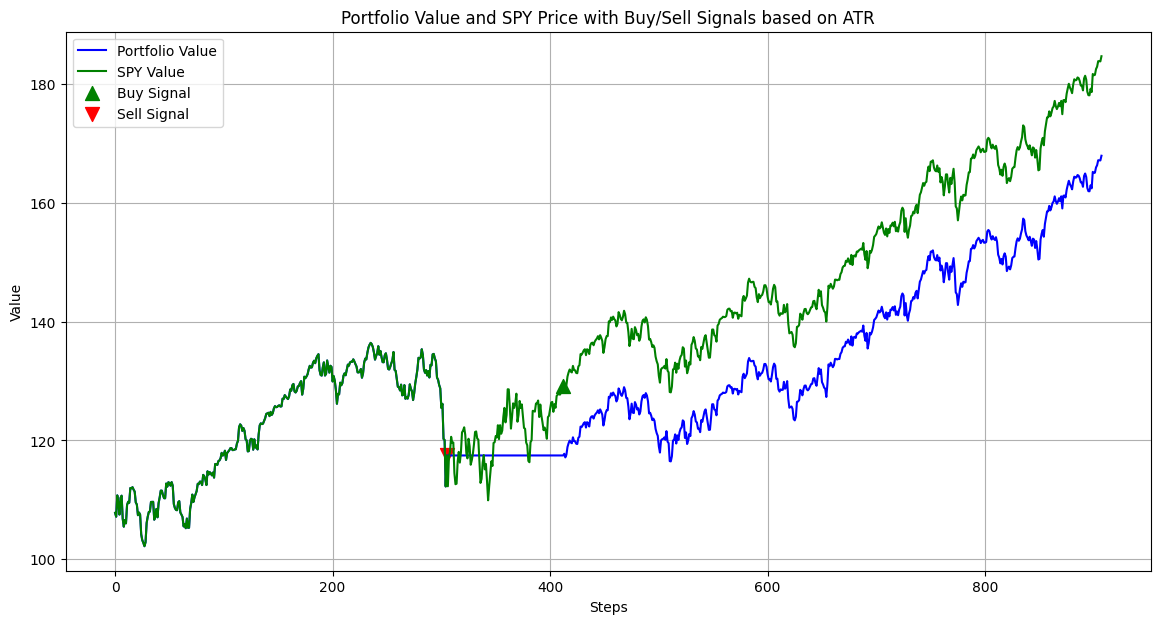

{'Sharpe Ratio': 0.9760324420911096,
 'Max Drawdown': 0.17716038874963103,
 'Total Profit': -11.719993591308594,
 'Cumulative P&L': 1.5575625900352734,
 'Order Book':    Date  Type       Price  Units
 0  3023   Buy  129.199997      1
 1  2916  Sell  117.480003      1}

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calcul de l'ATR
def calculate_atr(data, window):
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    atr = true_range.rolling(window=window, min_periods=1).mean()
    return atr

# Fonction de trading basée sur l'ATR
def trading_strategy_atr(data, atr_period=14, atr_low_threshold=1.5, atr_high_threshold=3.5, initial_stocks=1):
    data['ATR'] = calculate_atr(data, atr_period)

    money = 0
    stocks = initial_stocks
    portfolio_value = initial_stocks * data['Close'].iloc[0]
    print (data['Close'].iloc[0])
    print(portfolio_value)
    print(data.head())
    history = []
    buy_signals = []
    sell_signals = []

    for i in range(len(data)):
        price = data['Close'].iloc[i]
        atr = data['ATR'].iloc[i]

        if atr < atr_low_threshold and money > 0:
            # Buy signal
            stocks += money / price
            money = 0
            buy_signals.append((i, price))

        elif atr > atr_high_threshold and stocks > 0:
            # Sell signal
            money += stocks * price
            stocks = 0
            sell_signals.append((i, price))

        portfolio_value = money + stocks * price
        history.append((money, stocks, portfolio_value))

    return history, buy_signals, sell_signals

# Exécuter la stratégie
data_spy = pd.DataFrame(data_spy)  # Assurez-vous que data_spy est un DataFrame
atr_period = 14  # Période pour calculer l'ATR
atr_low_threshold = 1.5  # Seuil inférieur de l'ATR pour acheter
atr_high_threshold = 3.5  # Seuil supérieur de l'ATR pour vendre
history, buy_signals, sell_signals = trading_strategy_atr(data_spy, atr_period, atr_low_threshold, atr_high_threshold)

# Extraire les valeurs pour le tracé
steps = range(len(history))
money_values = [h[0] for h in history]
stock_values = [h[1] * data_spy['Close'].iloc[i] for i, h in enumerate(history)]
portfolio_values = [h[2] for h in history]
spy_values = data_spy['Close'].iloc[:len(history)].values
print(spy_values)

# Graphique de l'évolution du portefeuille et du prix de l'actif avec signaux d'achat et de vente
plt.figure(figsize=(14, 7))
plt.plot(steps, portfolio_values, label='Portfolio Value', color='b')
plt.plot(steps, spy_values, label='SPY Value', color='g')
plt.scatter([buy[0] for buy in buy_signals], [buy[1] for buy in buy_signals], color='green', marker='^', label='Buy Signal', s=100)
plt.scatter([sell[0] for sell in sell_signals], [sell[1] for sell in sell_signals], color='red', marker='v', label='Sell Signal', s=100)
plt.title('Portfolio Value and SPY Price with Buy/Sell Signals based on ATR')
plt.xlabel('Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Calcul des bénéfices totaux
buy_prices = [buy[1] for buy in buy_signals]
sell_prices = [sell[1] for sell in sell_signals]
num_trades = min(len(buy_prices), len(sell_prices))
profits = np.array(sell_prices[:num_trades]) - np.array(buy_prices[:num_trades])
total_profit = profits.sum()

# Calcul du Sharpe Ratio
portfolio_returns = pd.Series(portfolio_values).pct_change().dropna()
sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)

# Calcul du drawdown
cumulative_returns = (1 + portfolio_returns).cumprod()
peak = cumulative_returns.cummax()
drawdown = (peak - cumulative_returns) / peak
max_drawdown = drawdown.max()

# Création du carnet d'ordre
orders = []
for buy in buy_signals:
    orders.append({'Date': data_spy.index[buy[0]], 'Type': 'Buy', 'Price': buy[1], 'Units': 1})
for sell in sell_signals:
    orders.append({'Date': data_spy.index[sell[0]], 'Type': 'Sell', 'Price': sell[1], 'Units': 1})
orders_df = pd.DataFrame(orders)

# Retourner les résultats sous forme de dictionnaire
results_dict = {
    'Sharpe Ratio': sharpe_ratio,
    'Max Drawdown': max_drawdown,
    'Total Profit': total_profit,
    'Cumulative P&L': cumulative_returns.iloc[-1],
    'Order Book': orders_df
}

results_dict


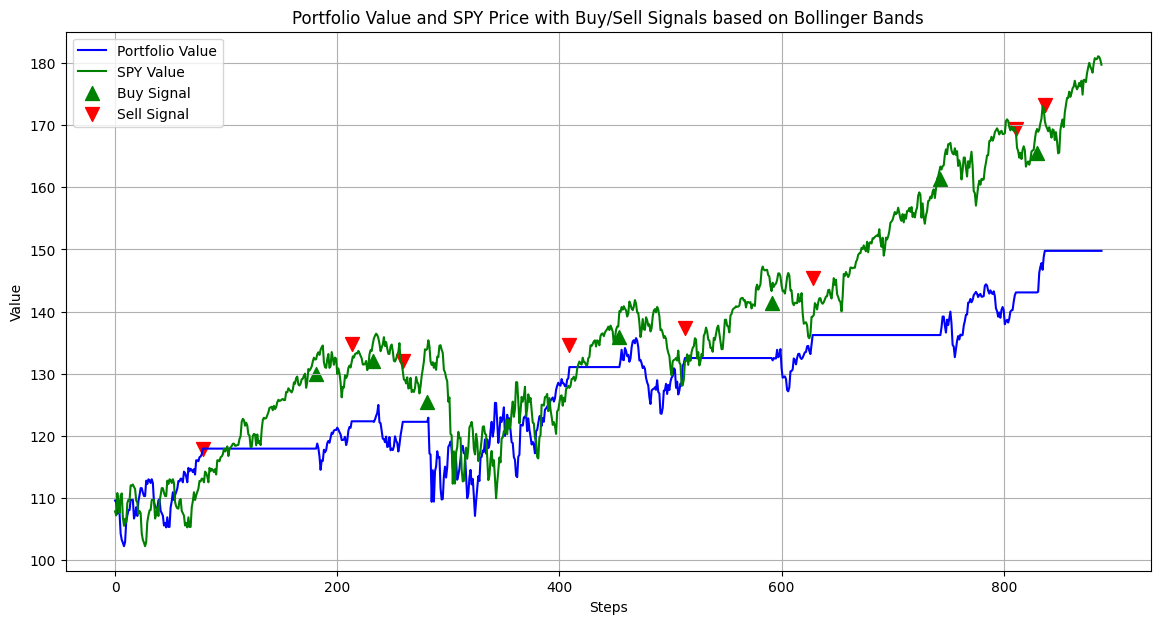

{'Sharpe Ratio': 0.698440913845688,
 'Max Drawdown': 0.14302054978940412,
 'Total Profit': -20.160011291503906,
 'Cumulative P&L': 1.3668850757853404,
 'Order Book':     Date  Type       Price  Units
 0   2792   Buy  129.940002      1
 1   2843   Buy  132.059998      1
 2   2892   Buy  125.489998      1
 3   3065   Buy  135.899994      1
 4   3202   Buy  141.419998      1
 5   3354   Buy  161.270004      1
 6   3441   Buy  165.479996      1
 7   2690  Sell  117.919998      1
 8   2824  Sell  134.789993      1
 9   2870  Sell  131.970001      1
 10  3020  Sell  134.539993      1
 11  3124  Sell  137.410004      1
 12  3239  Sell  145.369995      1
 13  3422  Sell  169.399994      1
 14  3448  Sell  173.220001      1}

In [107]:
def calculate_bollinger_bands(data, window, num_std_dev):
    sma = data['Close'].rolling(window).mean()
    rolling_std = data['Close'].rolling(window).std()
    bollinger_upper_band = sma + (rolling_std * num_std_dev)
    bollinger_lower_band = sma - (rolling_std * num_std_dev)
    return bollinger_upper_band, bollinger_lower_band

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calcul des bandes de Bollinger
def calculate_bollinger_bands(data, window, num_std_dev):
    sma = data['Close'].rolling(window).mean()
    rolling_std = data['Close'].rolling(window).std()
    bollinger_upper_band = sma + (rolling_std * num_std_dev)
    bollinger_lower_band = sma - (rolling_std * num_std_dev)
    return sma, bollinger_upper_band, bollinger_lower_band

# Fonction de trading basée sur les bandes de Bollinger
def trading_strategy_bollinger(data, window=20, num_std_dev=2, initial_stocks=1):
    sma, upper_band, lower_band = calculate_bollinger_bands(data, window, num_std_dev)
    data['SMA'] = sma
    data['Upper Band'] = upper_band
    data['Lower Band'] = lower_band
    data = data.dropna()

    money = 0
    stocks = initial_stocks
    portfolio_value = initial_stocks * data['Close'].iloc[0]
    history = []
    buy_signals = []
    sell_signals = []

    for i in range(len(data)):
        price = data['Close'].iloc[i]
        upper_band = data['Upper Band'].iloc[i]
        lower_band = data['Lower Band'].iloc[i]

        if price < lower_band and money > 0:
            # Buy signal
            stocks += money / price
            money = 0
            buy_signals.append((i, price))

        elif price > upper_band and stocks > 0:
            # Sell signal
            money += stocks * price
            stocks = 0
            sell_signals.append((i, price))

        portfolio_value = money + stocks * price
        history.append((money, stocks, portfolio_value))

    return history, buy_signals, sell_signals

# Exécuter la stratégie
data_spy = pd.DataFrame(data_spy)  # Assurez-vous que data_spy est un DataFrame
window = 20  # Période pour calculer les bandes de Bollinger
num_std_dev = 2  # Nombre d'écarts-types pour les bandes de Bollinger
history, buy_signals, sell_signals = trading_strategy_bollinger(data_spy, window, num_std_dev)

# Extraire les valeurs pour le tracé
steps = range(len(history))
money_values = [h[0] for h in history]
stock_values = [h[1] * data_spy['Close'].iloc[i] for i, h in enumerate(history)]
portfolio_values = [h[2] for h in history]
spy_values = data_spy['Close'].iloc[:len(history)].values

# Graphique de l'évolution du portefeuille et du prix de l'actif avec signaux d'achat et de vente
plt.figure(figsize=(14, 7))
plt.plot(steps, portfolio_values, label='Portfolio Value', color='b')
plt.plot(steps, spy_values, label='SPY Value', color='g')
plt.scatter([buy[0] for buy in buy_signals], [buy[1] for buy in buy_signals], color='green', marker='^', label='Buy Signal', s=100)
plt.scatter([sell[0] for sell in sell_signals], [sell[1] for sell in sell_signals], color='red', marker='v', label='Sell Signal', s=100)
plt.title('Portfolio Value and SPY Price with Buy/Sell Signals based on Bollinger Bands')
plt.xlabel('Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Calcul des bénéfices totaux
buy_prices = [buy[1] for buy in buy_signals]
sell_prices = [sell[1] for sell in sell_signals]
num_trades = min(len(buy_prices), len(sell_prices))
profits = np.array(sell_prices[:num_trades]) - np.array(buy_prices[:num_trades])
total_profit = profits.sum()

# Calcul du Sharpe Ratio
portfolio_returns = pd.Series(portfolio_values).pct_change().dropna()
sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)

# Calcul du drawdown
cumulative_returns = (1 + portfolio_returns).cumprod()
peak = cumulative_returns.cummax()
drawdown = (peak - cumulative_returns) / peak
max_drawdown = drawdown.max()

# Création du carnet d'ordre
orders = []
for buy in buy_signals:
    orders.append({'Date': data_spy.index[buy[0]], 'Type': 'Buy', 'Price': buy[1], 'Units': 1})
for sell in sell_signals:
    orders.append({'Date': data_spy.index[sell[0]], 'Type': 'Sell', 'Price': sell[1], 'Units': 1})
orders_df = pd.DataFrame(orders)

# Retourner les résultats sous forme de dictionnaire
results_dict = {
    'Sharpe Ratio': sharpe_ratio,
    'Max Drawdown': max_drawdown,
    'Total Profit': total_profit,
    'Cumulative P&L': cumulative_returns.iloc[-1],
    'Order Book': orders_df
}

results_dict


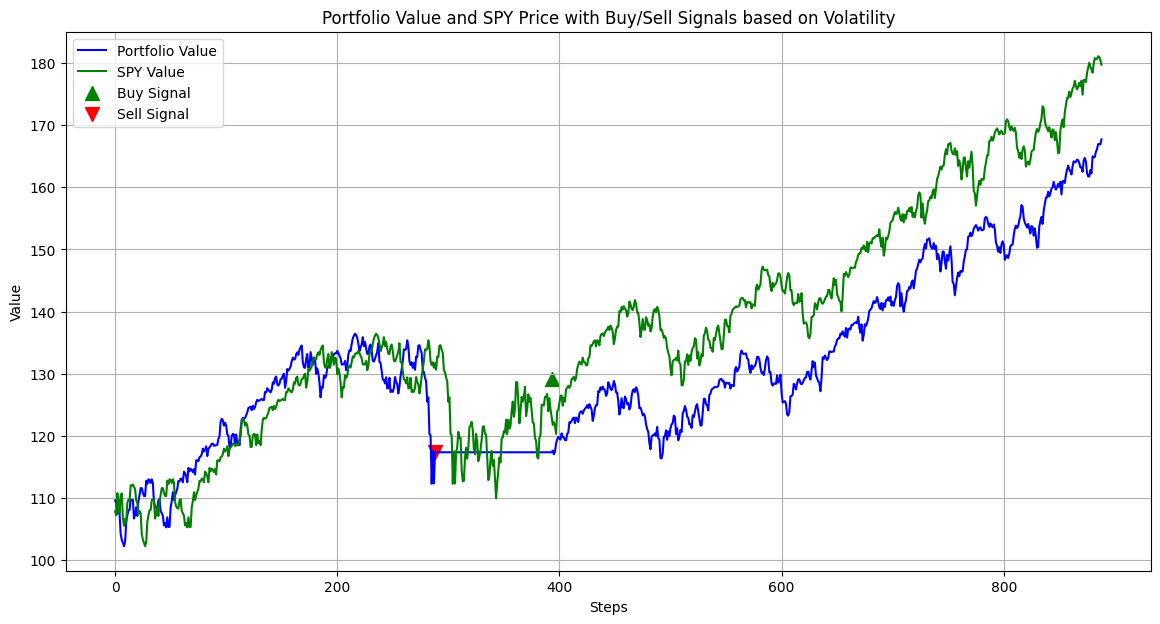

{'Sharpe Ratio': 0.960063865855299,
 'Max Drawdown': 0.17716038874963122,
 'Total Profit': -11.8699951171875,
 'Cumulative P&L': 1.5307289667397554,
 'Order Book':    Date  Type       Price  Units
 0  3004   Buy  129.199997      1
 1  2899  Sell  117.330002      1}

In [108]:
def calculate_volatility(data, window):
    log_returns = np.log(data / data.shift(1))
    rolling_std = log_returns.rolling(window=window).std()
    return rolling_std
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calcul de la volatilité
def calculate_volatility(data, window):
    log_returns = np.log(data / data.shift(1))
    rolling_std = log_returns.rolling(window=window).std()
    return rolling_std

# Fonction de trading basée sur la volatilité relative
def trading_strategy_volatility(data, volatility_window=14, low_volatility_threshold=0.01, high_volatility_threshold=0.03, initial_stocks=1):
    data['Volatility'] = calculate_volatility(data['Close'], volatility_window)
    data = data.dropna()

    money = 0
    stocks = initial_stocks
    portfolio_value = initial_stocks * data['Close'].iloc[0]
    history = []
    buy_signals = []
    sell_signals = []

    for i in range(len(data)):
        price = data['Close'].iloc[i]
        volatility = data['Volatility'].iloc[i]

        if volatility < low_volatility_threshold and money > 0:
            # Buy signal
            stocks += money / price
            money = 0
            buy_signals.append((i, price))

        elif volatility > high_volatility_threshold and stocks > 0:
            # Sell signal
            money += stocks * price
            stocks = 0
            sell_signals.append((i, price))

        portfolio_value = money + stocks * price
        history.append((money, stocks, portfolio_value))

    return history, buy_signals, sell_signals

# Exécuter la stratégie
data_spy = pd.DataFrame(data_spy)  # Assurez-vous que data_spy est un DataFrame
volatility_window = 14  # Période pour calculer la volatilité
low_volatility_threshold = 0.01  # Seuil inférieur de la volatilité pour acheter
high_volatility_threshold = 0.03  # Seuil supérieur de la volatilité pour vendre
history, buy_signals, sell_signals = trading_strategy_volatility(data_spy, volatility_window, low_volatility_threshold, high_volatility_threshold)

# Extraire les valeurs pour le tracé
steps = range(len(history))
money_values = [h[0] for h in history]
stock_values = [h[1] * data_spy['Close'].iloc[i] for i, h in enumerate(history)]
portfolio_values = [h[2] for h in history]
spy_values = data_spy['Close'].iloc[:len(history)].values

# Graphique de l'évolution du portefeuille et du prix de l'actif avec signaux d'achat et de vente
plt.figure(figsize=(14, 7))
plt.plot(steps, portfolio_values, label='Portfolio Value', color='b')
plt.plot(steps, spy_values, label='SPY Value', color='g')
plt.scatter([buy[0] for buy in buy_signals], [buy[1] for buy in buy_signals], color='green', marker='^', label='Buy Signal', s=100)
plt.scatter([sell[0] for sell in sell_signals], [sell[1] for sell in sell_signals], color='red', marker='v', label='Sell Signal', s=100)
plt.title('Portfolio Value and SPY Price with Buy/Sell Signals based on Volatility')
plt.xlabel('Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Calcul des bénéfices totaux
buy_prices = [buy[1] for buy in buy_signals]
sell_prices = [sell[1] for sell in sell_signals]
num_trades = min(len(buy_prices), len(sell_prices))
profits = np.array(sell_prices[:num_trades]) - np.array(buy_prices[:num_trades])
total_profit = profits.sum()

# Calcul du Sharpe Ratio
portfolio_returns = pd.Series(portfolio_values).pct_change().dropna()
sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)

# Calcul du drawdown
cumulative_returns = (1 + portfolio_returns).cumprod()
peak = cumulative_returns.cummax()
drawdown = (peak - cumulative_returns) / peak
max_drawdown = drawdown.max()

# Création du carnet d'ordre
orders = []
for buy in buy_signals:
    orders.append({'Date': data_spy.index[buy[0]], 'Type': 'Buy', 'Price': buy[1], 'Units': 1})
for sell in sell_signals:
    orders.append({'Date': data_spy.index[sell[0]], 'Type': 'Sell', 'Price': sell[1], 'Units': 1})
orders_df = pd.DataFrame(orders)

# Retourner les résultats sous forme de dictionnaire
results_dict = {
    'Sharpe Ratio': sharpe_ratio,
    'Max Drawdown': max_drawdown,
    'Total Profit': total_profit,
    'Cumulative P&L': cumulative_returns.iloc[-1],
    'Order Book': orders_df
}

results_dict


[*********************100%%**********************]  1 of 1 completed


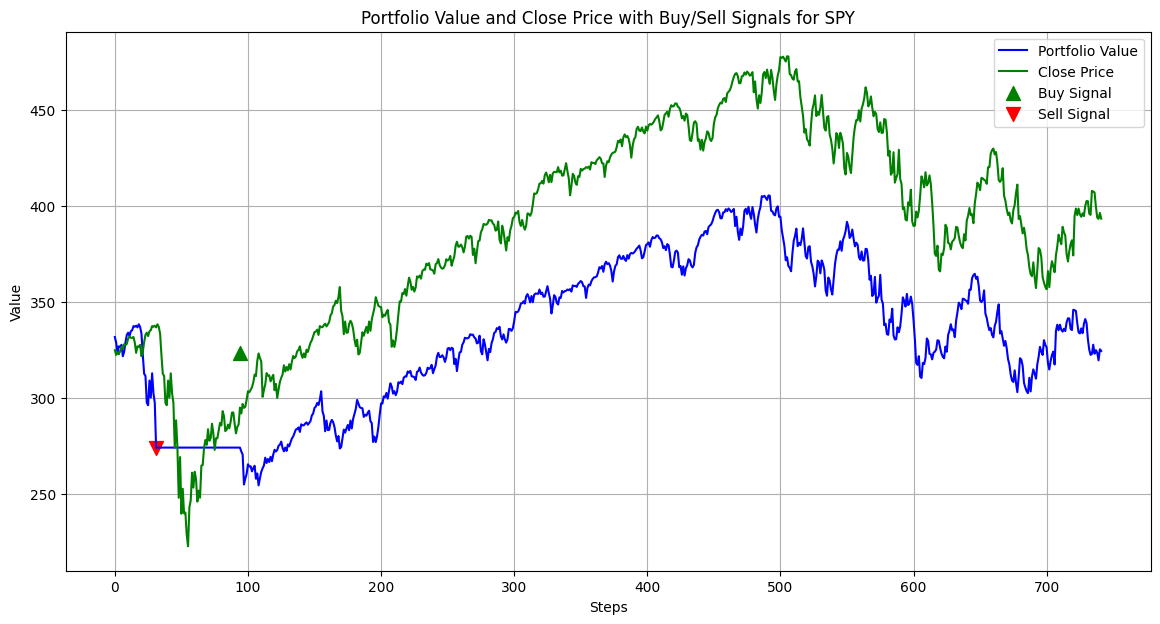

[*********************100%%**********************]  1 of 1 completed

S&P 500 Results: {'Sharpe Ratio': 0.06047892386253783, 'Max Drawdown': 0.2536057358303689, 'Total Profit': -48.970001220703125, 'Cumulative P&L': 0.9781915331533207, 'Order Book':         Date  Type       Price  Units
0 2020-05-18   Buy  323.200012      1
1 2020-02-18  Sell  274.230011      1}


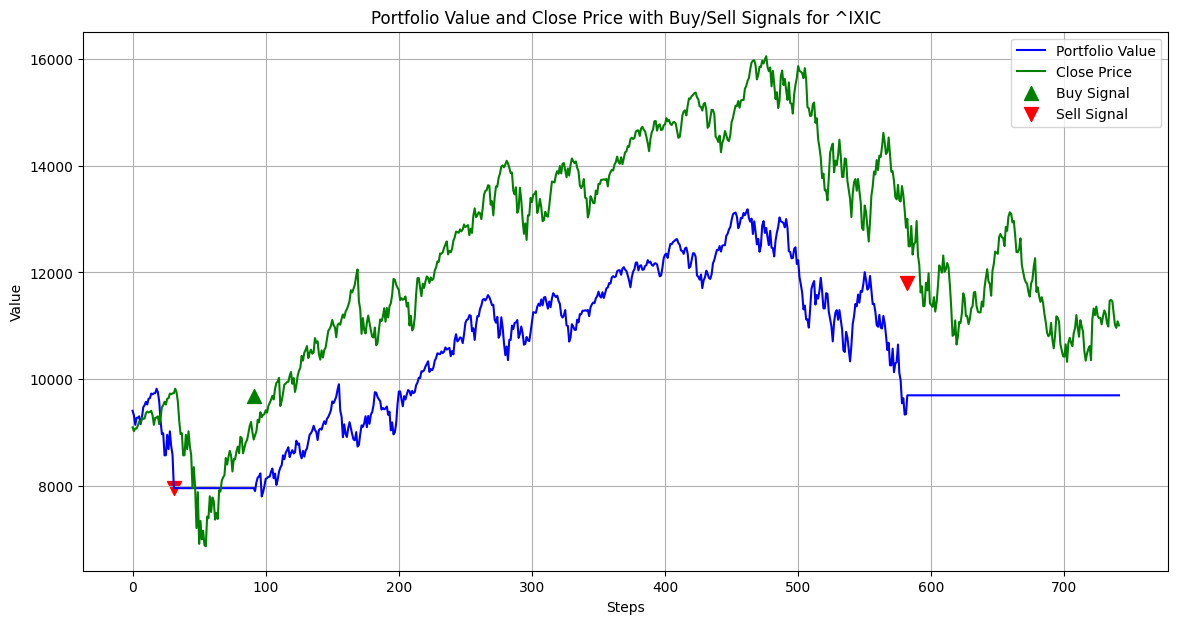

[*********************100%%**********************]  1 of 1 completed

NASDAQ Results: {'Sharpe Ratio': 0.15334630479366052, 'Max Drawdown': 0.29227573447107824, 'Total Profit': -1732.22998046875, 'Cumulative P&L': 1.0309128027471222, 'Order Book':         Date  Type         Price  Units
0 2020-05-13   Buy   9682.910156      1
1 2020-02-18  Sell   7950.680176      1
2 2022-04-25  Sell  11805.000000      1}


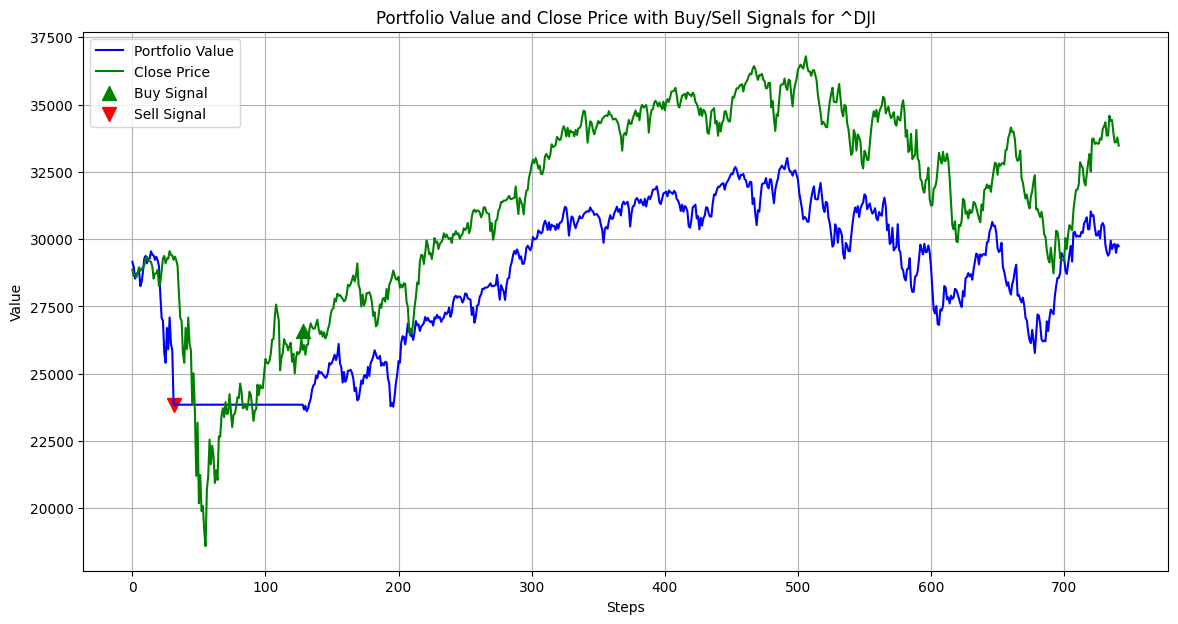

Dow Jones Results: {'Sharpe Ratio': 0.12481909464088967, 'Max Drawdown': 0.21940803824764768, 'Total Profit': -2733.75, 'Cumulative P&L': 1.0198415325741375, 'Order Book':         Date  Type         Price  Units
0 2020-07-07   Buy  26584.769531      1
1 2020-02-18  Sell  23851.019531      1}


In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Calcul de la volatilité
def calculate_volatility(data, window):
    log_returns = np.log(data / data.shift(1))
    rolling_std = log_returns.rolling(window=window).std()
    return rolling_std

# Fonction de trading basée sur la volatilité relative
def trading_strategy_volatility(data, volatility_window=14, low_volatility_threshold=0.01, high_volatility_threshold=0.03, initial_stocks=1):
    data['Volatility'] = calculate_volatility(data['Close'], volatility_window)
    data = data.dropna()

    money = 0
    stocks = initial_stocks
    portfolio_value = initial_stocks * data['Close'].iloc[0]
    history = []
    buy_signals = []
    sell_signals = []

    for i in range(len(data)):
        price = data['Close'].iloc[i]
        volatility = data['Volatility'].iloc[i]

        if volatility < low_volatility_threshold and money > 0:
            # Buy signal
            stocks += money / price
            money = 0
            buy_signals.append((i, price))

        elif volatility > high_volatility_threshold and stocks > 0:
            # Sell signal
            money += stocks * price
            stocks = 0
            sell_signals.append((i, price))

        portfolio_value = money + stocks * price
        history.append((money, stocks, portfolio_value))

    return history, buy_signals, sell_signals

# Fonction pour tester la stratégie sur un actif
def test_strategy(ticker, start_date, end_date, volatility_window=14, low_volatility_threshold=0.01, high_volatility_threshold=0.03):
    data = yf.download(ticker, start=start_date, end=end_date)
    if data.empty:
        print(f"No data for {ticker}")
        return None

    history, buy_signals, sell_signals = trading_strategy_volatility(data, volatility_window, low_volatility_threshold, high_volatility_threshold)

    # Extraire les valeurs pour le tracé
    steps = range(len(history))
    money_values = [h[0] for h in history]
    stock_values = [h[1] * data['Close'].iloc[i] for i, h in enumerate(history)]
    portfolio_values = [h[2] for h in history]
    close_values = data['Close'].iloc[:len(history)].values

    # Graphique de l'évolution du portefeuille et du prix de l'actif avec signaux d'achat et de vente
    plt.figure(figsize=(14, 7))
    plt.plot(steps, portfolio_values, label='Portfolio Value', color='b')
    plt.plot(steps, close_values, label='Close Price', color='g')
    plt.scatter([buy[0] for buy in buy_signals], [buy[1] for buy in buy_signals], color='green', marker='^', label='Buy Signal', s=100)
    plt.scatter([sell[0] for sell in sell_signals], [sell[1] for sell in sell_signals], color='red', marker='v', label='Sell Signal', s=100)
    plt.title(f'Portfolio Value and Close Price with Buy/Sell Signals for {ticker}')
    plt.xlabel('Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calcul des bénéfices totaux
    buy_prices = [buy[1] for buy in buy_signals]
    sell_prices = [sell[1] for sell in sell_signals]
    num_trades = min(len(buy_prices), len(sell_prices))
    profits = np.array(sell_prices[:num_trades]) - np.array(buy_prices[:num_trades])
    total_profit = profits.sum()

    # Calcul du Sharpe Ratio
    portfolio_returns = pd.Series(portfolio_values).pct_change().dropna()
    sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)

    # Calcul du drawdown
    cumulative_returns = (1 + portfolio_returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (peak - cumulative_returns) / peak
    max_drawdown = drawdown.max()

    # Création du carnet d'ordre
    orders = []
    for buy in buy_signals:
        orders.append({'Date': data.index[buy[0]], 'Type': 'Buy', 'Price': buy[1], 'Units': 1})
    for sell in sell_signals:
        orders.append({'Date': data.index[sell[0]], 'Type': 'Sell', 'Price': sell[1], 'Units': 1})
    orders_df = pd.DataFrame(orders)

    # Retourner les résultats sous forme de dictionnaire
    results_dict = {
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Total Profit': total_profit,
        'Cumulative P&L': cumulative_returns.iloc[-1],
        'Order Book': orders_df
    }

    return results_dict

# Test de la stratégie sur le S&P 500 (SPY)
spy_results = test_strategy('SPY', '2020-01-01', '2023-01-01')
print("S&P 500 Results:", spy_results)

# Test de la stratégie sur le NASDAQ (IXIC)
nasdaq_results = test_strategy('^IXIC', '2020-01-01', '2023-01-01')
print("NASDAQ Results:", nasdaq_results)

# Test de la stratégie sur le Dow Jones (DJI)
dow_jones_results = test_strategy('^DJI', '2020-01-01', '2023-01-01')
print("Dow Jones Results:", dow_jones_results)


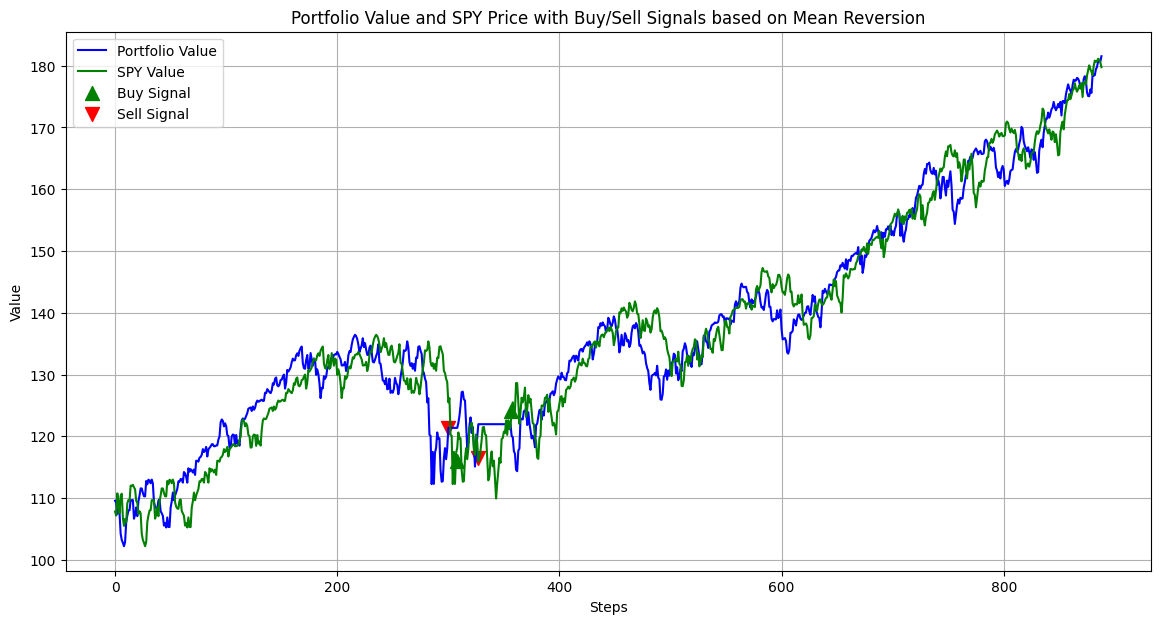

{'Sharpe Ratio': 1.0101386869194597,
 'Max Drawdown': 0.17716038874963122,
 'Total Profit': -2.1500015258789062,
 'Cumulative P&L': 1.6567454137735527,
 'Order Book':    Date  Type       Price  Units
 0  2919   Buy  115.919998      1
 1  2967   Buy  124.080002      1
 2  2911  Sell  121.360001      1
 3  2938  Sell  116.489998      1}

In [109]:
def calculate_moving_average(data, window):
    return data['Close'].rolling(window=window).mean()
def calculate_volatility(data, window):
    log_returns = np.log(data / data.shift(1))
    rolling_std = log_returns.rolling(window=window).std()
    return rolling_std
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calcul de la moyenne mobile
def calculate_moving_average(data, window):
    return data['Close'].rolling(window=window).mean()

# Calcul de la volatilité
def calculate_volatility(data, window):
    log_returns = np.log(data['Close'] / data['Close'].shift(1))
    rolling_std = log_returns.rolling(window=window).std()
    return rolling_std

# Fonction de trading basée sur la réversion à la moyenne
def trading_strategy_mean_reversion(data, ma_window=20, vol_window=14, vol_threshold=0.02, initial_stocks=1):
    data['MA'] = calculate_moving_average(data, ma_window)
    data['Volatility'] = calculate_volatility(data, vol_window)
    data = data.dropna()

    money = 0
    stocks = initial_stocks
    portfolio_value = initial_stocks * data['Close'].iloc[0]
    history = []
    buy_signals = []
    sell_signals = []

    for i in range(len(data)):
        price = data['Close'].iloc[i]
        ma = data['MA'].iloc[i]
        volatility = data['Volatility'].iloc[i]

        if price < ma and volatility < vol_threshold and money > 0:
            # Buy signal
            stocks += money / price
            money = 0
            buy_signals.append((i, price))

        elif price > ma and volatility > vol_threshold and stocks > 0:
            # Sell signal
            money += stocks * price
            stocks = 0
            sell_signals.append((i, price))

        portfolio_value = money + stocks * price
        history.append((money, stocks, portfolio_value))

    return history, buy_signals, sell_signals

# Exécuter la stratégie
data_spy = pd.DataFrame(data_spy)  # Assurez-vous que data_spy est un DataFrame
ma_window = 20  # Période pour calculer la moyenne mobile
vol_window = 14  # Période pour calculer la volatilité
vol_threshold = 0.02  # Seuil de la volatilité pour les décisions de trading
history, buy_signals, sell_signals = trading_strategy_mean_reversion(data_spy, ma_window, vol_window, vol_threshold)

# Extraire les valeurs pour le tracé
steps = range(len(history))
money_values = [h[0] for h in history]
stock_values = [h[1] * data_spy['Close'].iloc[i] for i, h in enumerate(history)]
portfolio_values = [h[2] for h in history]
spy_values = data_spy['Close'].iloc[:len(history)].values

# Graphique de l'évolution du portefeuille et du prix de l'actif avec signaux d'achat et de vente
plt.figure(figsize=(14, 7))
plt.plot(steps, portfolio_values, label='Portfolio Value', color='b')
plt.plot(steps, spy_values, label='SPY Value', color='g')
plt.scatter([buy[0] for buy in buy_signals], [buy[1] for buy in buy_signals], color='green', marker='^', label='Buy Signal', s=100)
plt.scatter([sell[0] for sell in sell_signals], [sell[1] for sell in sell_signals], color='red', marker='v', label='Sell Signal', s=100)
plt.title('Portfolio Value and SPY Price with Buy/Sell Signals based on Mean Reversion')
plt.xlabel('Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Calcul des bénéfices totaux
buy_prices = [buy[1] for buy in buy_signals]
sell_prices = [sell[1] for sell in sell_signals]
num_trades = min(len(buy_prices), len(sell_prices))
profits = np.array(sell_prices[:num_trades]) - np.array(buy_prices[:num_trades])
total_profit = profits.sum()

# Calcul du Sharpe Ratio
portfolio_returns = pd.Series(portfolio_values).pct_change().dropna()
sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)

# Calcul du drawdown
cumulative_returns = (1 + portfolio_returns).cumprod()
peak = cumulative_returns.cummax()
drawdown = (peak - cumulative_returns) / peak
max_drawdown = drawdown.max()

# Création du carnet d'ordre
orders = []
for buy in buy_signals:
    orders.append({'Date': data_spy.index[buy[0]], 'Type': 'Buy', 'Price': buy[1], 'Units': 1})
for sell in sell_signals:
    orders.append({'Date': data_spy.index[sell[0]], 'Type': 'Sell', 'Price': sell[1], 'Units': 1})
orders_df = pd.DataFrame(orders)

# Retourner les résultats sous forme de dictionnaire
results_dict = {
    'Sharpe Ratio': sharpe_ratio,
    'Max Drawdown': max_drawdown,
    'Total Profit': total_profit,
    'Cumulative P&L': cumulative_returns.iloc[-1],
    'Order Book': orders_df
}

results_dict


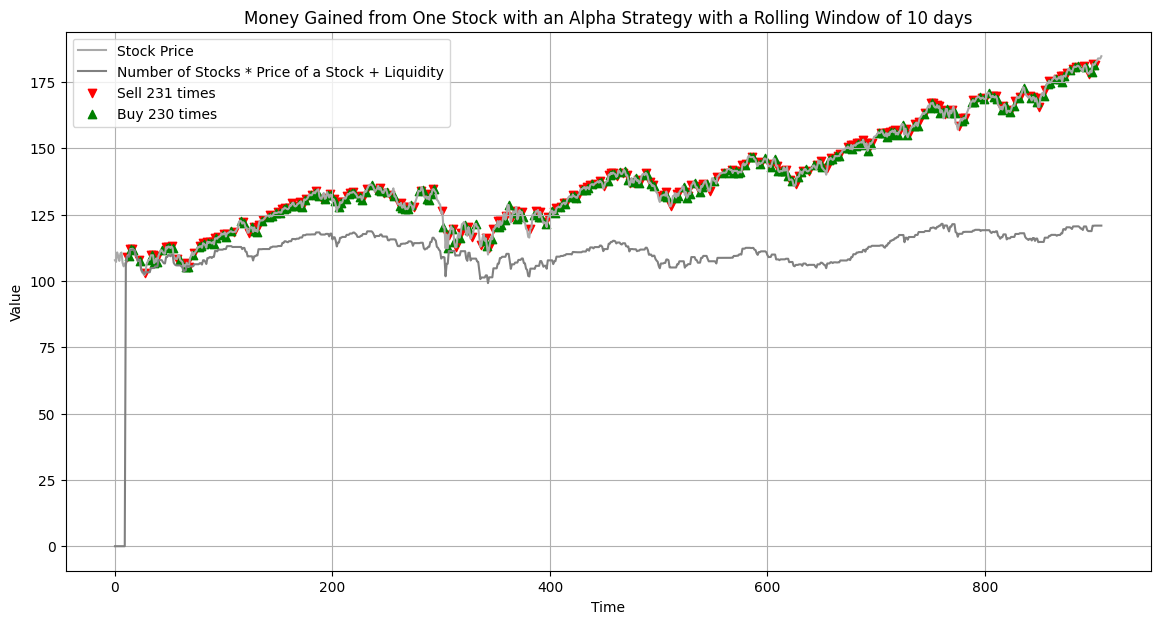

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simuler les gains en fonction d'un alpha donné
def simu_gain(alpha, Close):
    Stocks = 1 
    Money = 0
    MTotal = []
    for k in range(len(Close)):
        MTotal.append(Stocks * Close[k] + Money)
        if Close[k] - Close[k-1] > alpha and Stocks > 0:  # Sell
            Money = Stocks * Close[k]  # On vend tout
            Stocks = 0
        elif Close[k] - Close[k-1] < -alpha and Money > 0:  # Buy
            Stocks = Money / Close[k]
            Money = 0
    return MTotal

# Simuler l'évolution en fonction de la fenêtre de roulement
def simu_evo(Close, span):
    X1, X2, Y1, Y2 = [], [], [], []
    Stocks = 1 
    Money = 0
    MTotal = []
    alpha = alphaevo(Close[:span])
    for k in range(span, len(Close)):
        alpha = alphaevo(Close[k-span:k])
        MTotal.append(Stocks * Close[k] + Money)
        if Close[k] - Close[k-1] > alpha and Stocks > 0:  # Sell
            X1.append(k)
            Y1.append(Close[k])
            Money = Stocks * Close[k]  # On vend tout
            Stocks = 0
        elif Close[k] - Close[k-1] < -alpha and Money > 0:  # Buy
            X2.append(k)
            Y2.append(Close[k])
            Stocks = Money / Close[k]
            Money = 0
    return MTotal, X1, Y1, X2, Y2

# Calculer l'alpha optimal
def alphaevo(Close):
    Mmax = 0
    optimal_alpha = 0
    for k in np.arange(-0.1, 0.1, 0.01):  # Ajustez l'intervalle et le pas si nécessaire
        MTotal = simu_gain(k, Close)
        if MTotal[-1] > Mmax:
            optimal_alpha = k
            Mmax = MTotal[-1]
    return optimal_alpha

# Charger les données
data_spy = pd.DataFrame(data_spy)  # Assurez-vous que data_spy est un DataFrame
Close = data_spy['Close'].values

# Définir la fenêtre de roulement
rolling_window = 10

# Exécuter la simulation
MTotal, X1, Y1, X2, Y2 = simu_evo(Close, rolling_window)
MTotal2 = np.array([0 for k in range(rolling_window)] + MTotal)

# Graphique de l'évolution du portefeuille et du prix de l'actif avec signaux d'achat et de vente
plt.figure(figsize=(14, 7))
plt.plot(Close, color='darkgrey', label="Stock Price")
plt.plot(MTotal2, color='grey', label="Number of Stocks * Price of a Stock + Liquidity")
plt.scatter(X1, Y1, color='red', marker='v', label='Sell ' + str(len(X1)) + ' times')
plt.scatter(X2, Y2, color='green', marker='^', label='Buy ' + str(len(X2)) + ' times')
plt.title("Money Gained from One Stock with an Alpha Strategy with a Rolling Window of " + str(rolling_window) + " days")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()


[*********************100%%**********************]  1 of 1 completed


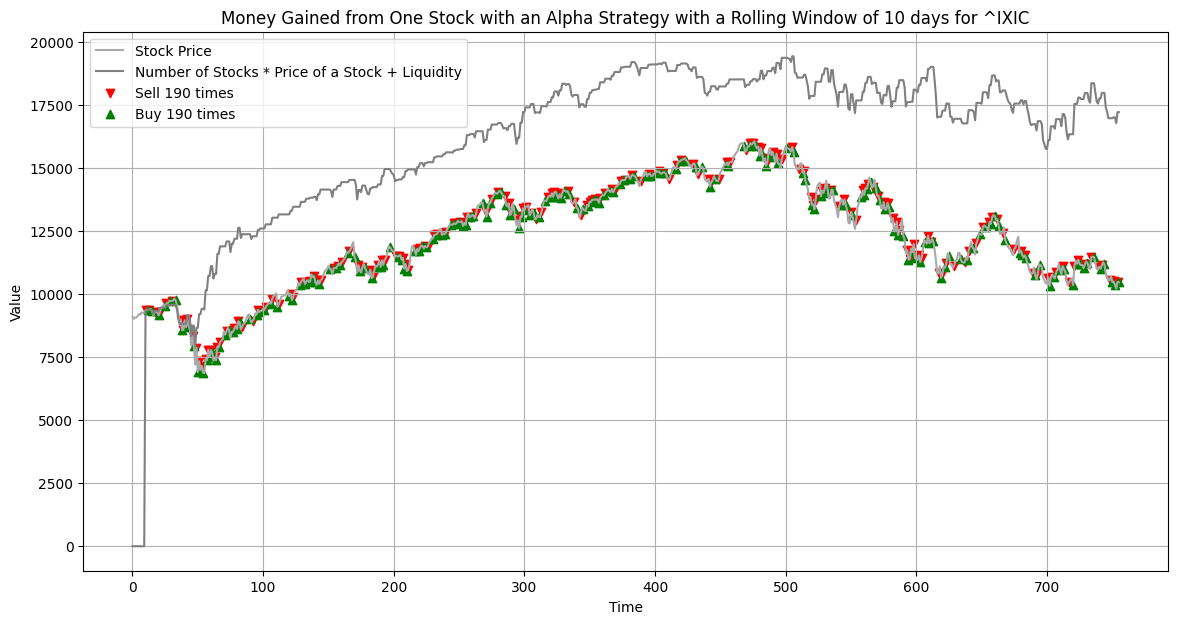

[*********************100%%**********************]  1 of 1 completed

NASDAQ Results: {'Sharpe Ratio': nan, 'Max Drawdown': nan, 'Total Profit': 4744.99951171875, 'Cumulative P&L': inf, 'Order Book':           Date  Type         Price  Units
0   2020-01-16  Sell   9357.129883      1
1   2020-01-22  Sell   9383.769531      1
2   2020-01-28  Sell   9269.679688      1
3   2020-02-03  Sell   9273.400391      1
4   2020-02-10  Sell   9628.389648      1
..         ...   ...           ...    ...
375 2022-12-09   Buy  11004.620117      1
376 2022-12-14   Buy  11170.889648      1
377 2022-12-22   Buy  10476.120117      1
378 2022-12-27   Buy  10353.230469      1
379 2022-12-30   Buy  10466.480469      1

[380 rows x 4 columns]}


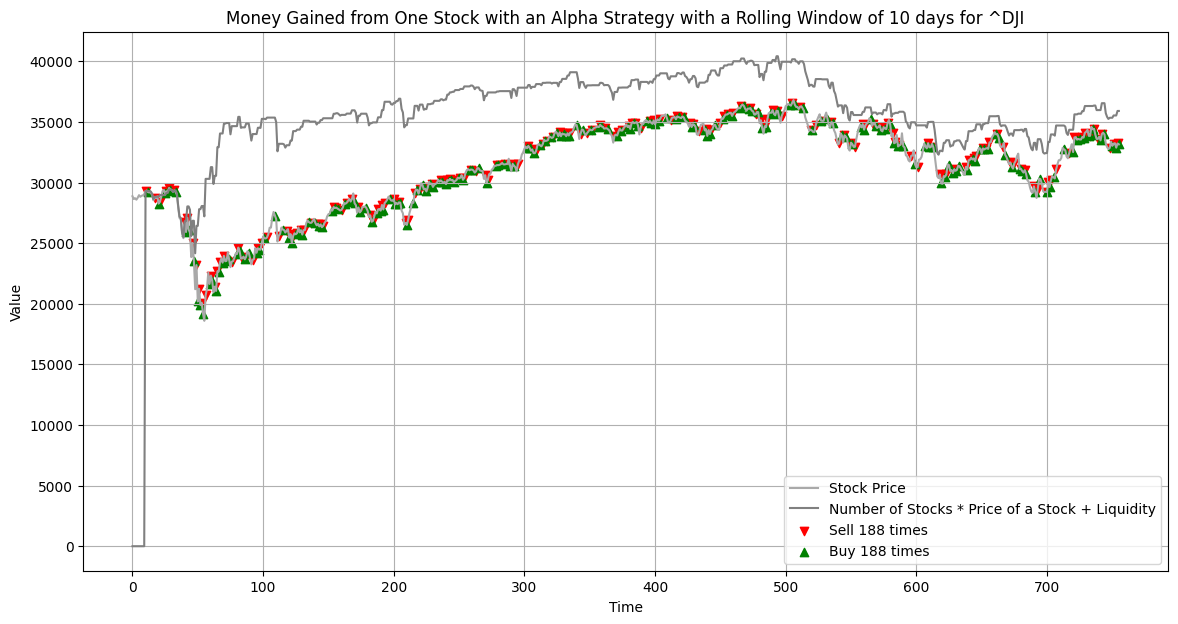

Dow Jones Results: {'Sharpe Ratio': nan, 'Max Drawdown': nan, 'Total Profit': -222.423828125, 'Cumulative P&L': inf, 'Order Book':           Date  Type         Price  Units
0   2020-01-16  Sell  29297.640625      1
1   2020-01-28  Sell  28722.849609      1
2   2020-02-03  Sell  28399.810547      1
3   2020-02-10  Sell  29276.820312      1
4   2020-02-12  Sell  29551.419922      1
..         ...   ...           ...    ...
371 2022-12-09   Buy  33476.460938      1
372 2022-12-14   Buy  33966.351562      1
373 2022-12-22   Buy  33027.488281      1
374 2022-12-28   Buy  32875.710938      1
375 2022-12-30   Buy  33147.250000      1

[376 rows x 4 columns]}


In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Simuler les gains en fonction d'un alpha donné
def simu_gain(alpha, Close):
    Stocks = 1 
    Money = 0
    MTotal = []
    for k in range(1, len(Close)):
        MTotal.append(Stocks * Close[k] + Money)
        if Close[k] - Close[k-1] > alpha and Stocks > 0:  # Sell
            Money = Stocks * Close[k]  # On vend tout
            Stocks = 0
        elif Close[k] - Close[k-1] < -alpha and Money > 0:  # Buy
            Stocks = Money / Close[k]
            Money = 0
    return MTotal

# Simuler l'évolution en fonction de la fenêtre de roulement
def simu_evo(Close, span):
    X1, X2, Y1, Y2 = [], [], [], []
    Stocks = 1 
    Money = 0
    MTotal = []
    alpha = alphaevo(Close[:span])
    for k in range(span, len(Close)):
        alpha = alphaevo(Close[k-span:k])
        MTotal.append(Stocks * Close[k] + Money)
        if Close[k] - Close[k-1] > alpha and Stocks > 0:  # Sell
            X1.append(k)
            Y1.append(Close[k])
            Money = Stocks * Close[k]  # On vend tout
            Stocks = 0
        elif Close[k] - Close[k-1] < -alpha and Money > 0:  # Buy
            X2.append(k)
            Y2.append(Close[k])
            Stocks = Money / Close[k]
            Money = 0
    return MTotal, X1, Y1, X2, Y2

# Calculer l'alpha optimal
def alphaevo(Close):
    Mmax = 0
    optimal_alpha = 0
    for k in np.arange(-0.1, 0.1, 0.01):  # Ajustez l'intervalle et le pas si nécessaire
        MTotal = simu_gain(k, Close)
        if MTotal[-1] > Mmax:
            optimal_alpha = k
            Mmax = MTotal[-1]
    return optimal_alpha

# Fonction pour tester la stratégie sur un actif
def test_alpha_strategy(ticker, start_date, end_date, rolling_window=10):
    data = yf.download(ticker, start=start_date, end=end_date)
    if data.empty:
        print(f"No data for {ticker}")
        return None

    Close = data['Close'].values
    MTotal, X1, Y1, X2, Y2 = simu_evo(Close, rolling_window)
    MTotal2 = np.array([0 for _ in range(rolling_window)] + MTotal)

    # Graphique de l'évolution du portefeuille et du prix de l'actif avec signaux d'achat et de vente
    plt.figure(figsize=(14, 7))
    plt.plot(Close, color='darkgrey', label="Stock Price")
    plt.plot(MTotal2, color='grey', label="Number of Stocks * Price of a Stock + Liquidity")
    plt.scatter(X1, Y1, color='red', marker='v', label='Sell ' + str(len(X1)) + ' times')
    plt.scatter(X2, Y2, color='green', marker='^', label='Buy ' + str(len(X2)) + ' times')
    plt.title(f"Money Gained from One Stock with an Alpha Strategy with a Rolling Window of {rolling_window} days for {ticker}")
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

    # Calcul des bénéfices totaux
    buy_prices = [Y2[i] for i in range(len(Y2))]
    sell_prices = [Y1[i] for i in range(len(Y1))]
    num_trades = min(len(buy_prices), len(sell_prices))
    profits = np.array(sell_prices[:num_trades]) - np.array(buy_prices[:num_trades])
    total_profit = profits.sum()

    # Calcul du Sharpe Ratio
    portfolio_returns = pd.Series(MTotal2).pct_change().dropna()
    sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)

    # Calcul du drawdown
    cumulative_returns = (1 + portfolio_returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (peak - cumulative_returns) / peak
    max_drawdown = drawdown.max()

    # Création du carnet d'ordre
    orders = []
    for i in range(len(X1)):
        orders.append({'Date': data.index[X1[i]], 'Type': 'Sell', 'Price': Y1[i], 'Units': 1})
    for i in range(len(X2)):
        orders.append({'Date': data.index[X2[i]], 'Type': 'Buy', 'Price': Y2[i], 'Units': 1})
    orders_df = pd.DataFrame(orders)

    # Retourner les résultats sous forme de dictionnaire
    results_dict = {
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Total Profit': total_profit,
        'Cumulative P&L': cumulative_returns.iloc[-1],
        'Order Book': orders_df
    }

    return results_dict

# Test de la stratégie sur le NASDAQ (IXIC)
nasdaq_results = test_alpha_strategy('^IXIC', '2020-01-01', '2023-01-01')
print("NASDAQ Results:", nasdaq_results)

# Test de la stratégie sur le Dow Jones (DJI)
dow_jones_results = test_alpha_strategy('^DJI', '2020-01-01', '2023-01-01')
print("Dow Jones Results:", dow_jones_results)
